In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ranksums, wilcoxon ,spearmanr, pearsonr, kruskal, zscore, fisher_exact, ttest_ind, mannwhitneyu
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import fcluster

from itertools import combinations
from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm

import gseapy as gp

import os
os.chdir('/scratch/svc_td_compbio/users/kiviaho/hillock_club_senescence')

# Load gene modules
gene_modules = pd.read_excel('/home/ak431480/prostate_lineage_signatures.xlsx',skiprows=1)
gene_modules = gene_modules.drop(columns='Housekeeping')
gene_modules_dict = gene_modules.to_dict('list')
for k in gene_modules_dict:
    gene_modules_dict[k] = [g for g in gene_modules_dict[k] if str(g) != 'nan']


def extract_gene_mapping(gtf_file, mapping_type='ENSG'):
    gene_mapping = {}

    with open(gtf_file, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            columns = line.strip().split('\t')
            if columns[2] == 'gene':
                attributes = columns[8].split('; ')
                gene_id = None
                gene_name = None
                for attribute in attributes:
                    if mapping_type == 'ENSG' and attribute.startswith('gene_id'):
                        gene_id = attribute.split(' ')[1].strip('"')
                    elif mapping_type == 'NCBI' and attribute.startswith('gene_id'):
                        gene_id = attribute.split(' ')[1].strip('"')
                    elif attribute.startswith('gene_name'):
                        gene_name = attribute.split(' ')[1].strip('"')
                if gene_id and gene_name:
                    gene_mapping[gene_id] = gene_name

    return pd.DataFrame(list(gene_mapping.items()), columns=['gene_id', 'gene_name'])

# Example usage:
# df = extract_gene_mapping('your_gtf_file.gtf', mapping_type='NCBI')

def extract_gene_lengths_from_gtf(file_path):
    gene_lengths = {}

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            data = line.strip().split('\t')
            if data[2] == 'gene':
                attributes = data[8].split(';')
                gene_name = [x.split('"')[1] for x in attributes if 'gene_name' in x][0]
                start = int(data[3])
                end = int(data[4])
                length = end - start + 1
                gene_lengths[gene_name] = length

    return gene_lengths


# Function to calculate TPM
def calculate_tpm(df,gene_lengths_per_kb):

    # Gene reads per kilobase
    df_rpk = df.divide(gene_lengths_per_kb,axis=0)

    # Total rpk per sample 
    sample_scaling_factor = df_rpk.sum()/1e6

    # TPM
    tpm_df = df_rpk.divide(sample_scaling_factor)

    return tpm_df

def remove_overlaps(data):
    # Convert lists to sets for easier comparison
    sets = {k: set(v) for k, v in data.items()}
    
    # Iterate over each pair of lists
    for key1, set1 in sets.items():
        for key2, set2 in sets.items():
            if key1 != key2:
                # Find the intersection
                intersection = set1 & set2
                if intersection:
                    # Remove intersection from the longer list
                    if len(set1) > len(set2):
                        sets[key1] -= intersection
                    else:
                        sets[key2] -= intersection
    
    # Convert sets back to lists
    return {k: list(v) for k, v in sets.items()}


def regress_out_signature(df, signature):
    # Extract the signature column
    signature_scores = df[signature]
    
    # Regress out the signature from each column
    for col in df.columns:
        if col != signature:
            X = sm.add_constant(signature_scores)
            y = df[col]
            model = sm.OLS(y, X).fit()
            df[col] = model.resid

    df = df.drop(columns=signature)
    
    return df

def regress_out_signatures(df, signatures):
    # Create the design matrix with a constant and all signature columns
    X = sm.add_constant(df[signatures])
    
    # Regress out the signatures from each column
    for col in df.columns:
        if col not in signatures:
            y = df[col]
            model = sm.OLS(y, X).fit()
            df[col] = model.resid
    
    # Remove the signature columns from the DataFrame
    df = df.drop(columns=signatures)
    
    return df


plot_save_path = '/scratch/svc_td_compbio/users/kiviaho/hillock_club_senescence/'


## ARNEO gene set scores and group comparisons

In [9]:
run_GSVA = True
# Using the real set of RNA-seq data

rnaseq_data = pd.read_csv('./data/arneo-rnaseq/TR169-arneo-tpm-star-rsem.csv',index_col=0)
metadata = pd.read_csv('./data/arneo-rnaseq/case-metadata.txt',index_col=0,sep='\t')

rnaseq_data = rnaseq_data.drop(columns=['ensembl_gene_id','entrezgene_id']).set_index('hgnc_symbol')

missing_meta = pd.DataFrame({
    'TRT_GROUP':np.repeat('treatment-naive',len(rnaseq_data.columns.difference(metadata.index))),
    'tc': np.nan,
    'tc_method': np.nan,
    }, index = rnaseq_data.columns.difference(metadata.index)
    )

metadata = pd.concat([metadata,missing_meta])

# Create a treatment-naive vs neoadjuvant-treated divide
metadata['TRT_GROUP_SIMPLE'] = pd.Categorical(metadata['TRT_GROUP'].map({'treatment-naive':'treatment-naive','adt':'neoadjuvant-treated','adt_apa':'neoadjuvant-treated'}),categories=['treatment-naive','neoadjuvant-treated'])
metadata['tc'] = metadata['tc'].astype('float')

# ONLY KEEP THE TREATMENT-NAIVE PWB SAMPLES

# Match the ordering
overlap = rnaseq_data.columns.intersection(metadata.index)
rnaseq_data = rnaseq_data[overlap]
metadata = metadata.loc[overlap]

# Match gene names to those in signatures
gene_alias_dict = {
    'ACP3' : 'ACPP',
    'CCN1' : 'CYR61',
    'SHLD2' : 'FAM35A',
    'TENT5C': 'FAM46C',
    'TAFA5' : 'FAM19A5',
    'GET3' : 'ASNA1',
}

rnaseq_data = rnaseq_data.rename(index=gene_alias_dict)

if run_GSVA:
    # Log2 transform
    gsva_res = gp.gsva(data=np.log2(rnaseq_data),gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
    gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')
    gsva_res_df = gsva_res_df.set_index('Sample Identifier').astype('float')

    gsva_res_df = gsva_res_df.loc[overlap]

    if (gsva_res_df.index == metadata.index).all():
        dat = pd.concat([gsva_res_df,metadata], axis=1)

else:
    # Simpler median z-score summary
    rnaseq_data_zscore = zscore(rnaseq_data,axis=1)

    # Calculate median Z-score of the set of genes
    median_zscore = pd.DataFrame(columns = gene_modules_dict.keys(),index = rnaseq_data_zscore.columns)
    for k in gene_modules_dict:
        sig = rnaseq_data_zscore.index.intersection(gene_modules_dict[k])
        median_zscore[k] = rnaseq_data_zscore.loc[sig].median()

    if (median_zscore.index == metadata.index).all():
        dat = pd.concat([median_zscore,metadata], axis=1)

# Create the ARNEO 
dat['PTEN_LOSS_LIU'] = dat['PTEN_LOSS_UP'] - dat['PTEN_LOSS_DOWN']

dat['TRT_GROUP'] = pd.Categorical(dat['TRT_GROUP'],categories=['treatment-naive','adt','adt_apa']).remove_unused_categories()
dat['TRT_GROUP_SIMPLE'] = pd.Categorical(dat['TRT_GROUP'].map({'treatment-naive':'treatment-naive','adt':'neoadjuvant-treated','adt_apa':'neoadjuvant-treated'}),categories=['treatment-naive','neoadjuvant-treated'])

arneo_scoring_data = dat.copy()

/home/ak431480/.local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
2026-01-20 08:30:42,379 [WARNING] Found duplicated gene names, values averaged by gene names!
2026-01-20 08:30:42,491 [WARNING] Input gene rankings contains inf values!


In [64]:
dat = dat[dat['TRT_GROUP'] == 'treatment-naive']
#dat

In [66]:
## Add clinical data

arneo_clinical = pd.read_excel('/home/ak431480/ARNEO DATABASE_ONCO_FINAL.xlsx',index_col='PatientNumber')
arneo_clinical.index = arneo_clinical.index.astype(str).str.replace('32','ARN')
arneo_clinical.index = arneo_clinical.index.astype(str).str.replace('ARN0ARN','ARN032')
dat_with_clinical = pd.merge(dat,arneo_clinical,left_index=True,right_index=True)

In [68]:
dat

,B1_Basal-ESR1,B2_Basal,B3_Basal-GPRC5A,B4_Basal,B5_Basal-VCAN,B6_Basal-IC1,BPECT Basal Identity,BPECT Club Identity,BPECT Hillock Identity,BPECT Luminal Identity,...,d2_dLum-KRT4,d3_dLum-LTF,d4_dLum-NKX3-1,d5_dLum,d6_dLum-CNMD,TRT_GROUP,tc,tc_method,TRT_GROUP_SIMPLE,PTEN_LOSS_LIU
PWB001,-0.074200,-0.560957,0.640859,0.422114,-0.034384,-0.367985,-0.067238,0.347278,0.458300,0.226486,...,0.410680,0.108178,-0.037348,0.023770,-0.106627,treatment-naive,0.25,lpwgs,treatment-naive,-0.217959
PWB002,-0.310334,-0.089879,-0.113130,-0.357004,-0.113168,0.136733,-0.398630,0.026383,0.081211,0.338375,...,-0.238975,-0.016091,0.463442,-0.524164,-0.398226,treatment-naive,0.52,lpwgs,treatment-naive,1.475025
PWB003,-0.583857,-0.557850,-0.001289,-0.371069,-0.193536,-0.359883,-0.601063,-0.237854,-0.150266,0.538848,...,-0.378326,-0.330598,0.403448,-0.131198,-0.468351,treatment-naive,0.23,lpwgs,treatment-naive,0.834490
PWB004,-0.675286,-0.804809,-0.515146,-0.157760,-0.469937,-0.337818,-0.557313,0.196467,-0.461895,0.313637,...,-0.026207,0.277507,0.544722,-0.662486,-0.425942,treatment-naive,0.50,lpwgs,treatment-naive,-0.010425
PWB008,-0.719916,-0.676081,-0.497928,-0.726066,-0.501923,-0.339951,-0.642011,-0.641272,-0.540027,0.170076,...,-0.644164,-0.553448,-0.017643,-0.519963,-0.428091,treatment-naive,0.70,lpwgs,treatment-naive,0.951379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PWB062,0.488438,0.457291,0.454846,0.410172,0.023428,0.238734,0.530349,-0.153410,0.300665,-0.037609,...,0.399144,0.424618,-0.022523,0.198060,0.641485,treatment-naive,NaN,NaN,treatment-naive,-0.474634
PWB063,-0.755539,-0.697004,-0.718911,-0.280984,-0.321644,-0.594152,-0.652967,-0.307919,-0.548150,0.325950,...,-0.505285,-0.286464,-0.100594,-0.627497,-0.649856,treatment-naive,NaN,NaN,treatment-naive,-0.766325
PWB064,-0.672894,-0.175786,-0.301305,-0.215409,-0.088085,-0.280196,-0.525014,-0.089942,-0.122658,0.542890,...,-0.179639,0.462023,0.601983,-0.365797,-0.333742,treatment-naive,NaN,NaN,treatment-naive,-0.855755
PWB065,0.101108,-0.548295,0.176868,0.658664,0.207675,-0.377600,-0.169315,0.446279,0.136938,0.427995,...,0.581419,0.119171,0.184214,-0.479211,-0.361356,treatment-naive,NaN,NaN,treatment-naive,0.339554


### Addressing PTEN status

In [70]:
dat.value_counts()

B1_Basal-ESR1  B2_Basal   B3_Basal-GPRC5A  B4_Basal   B5_Basal-VCAN  B6_Basal-IC1  BPECT Basal Identity  BPECT Club Identity  BPECT Hillock Identity  BPECT Luminal Identity  Basal      CRPC-AR    CRPC-NE    CRPC-SCL   CRPC-WNT   Duct luminal  HALLMARK_ANDROGEN_RESPONSE  HALLMARK_IL6_JAK_STAT3_SIGNALING  HALLMARK_INTERFERON_ALPHA_RESPONSE  HALLMARK_INTERFERON_GAMMA_RESPONSE  HALLMARK_PI3K_AKT_MTOR_SIGNALING  HALLMARK_TNFA_SIGNALING_VIA_NFKB  IL1B MDSCs  JAK_STAT_FGFR  Luminal   Lum−LTF    Lum−SFTPA2  Lum−TGM4   Lum−type1  Lum−type2  PMN-MDSCs  PTEN_LOSS_DOWN  PTEN_LOSS_UP  Prostate_progenitor  REACTOME_SIGNALING_BY_RETINOIC_ACID  SOX4_REGULON  SOX4_REGULON_LONG  TISS       TISS long  d1_dLum-Club  d2_dLum-KRT4  d3_dLum-LTF  d4_dLum-NKX3-1  d5_dLum    d6_dLum-CNMD  TRT_GROUP        tc    tc_method  TRT_GROUP_SIMPLE  PTEN_LOSS_LIU
-0.734989      -0.601105  -0.657405         0.014495  -0.105402      -0.341073     -0.611945              0.022735            -0.381368               0.561322  

SignificanceResult(statistic=-0.12924378635642517, pvalue=0.32084895633765104)

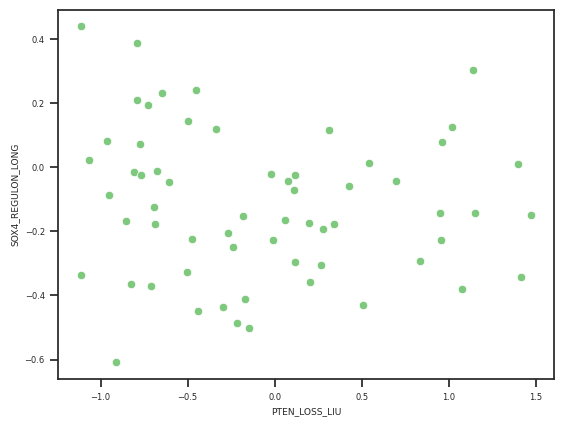

In [69]:
df_small = dat.copy()
sig = 'PTEN_LOSS_LIU'
sig2 = 'SOX4_REGULON_LONG'#'TISS'

sns.scatterplot(
    df_small,
    x = sig,
    y = sig2,
    #hue='PTEN binary'

)

spearmanr(df_small[sig],df_small[sig2])

### Plot the treatment-induced score change

/tmp/ipykernel_16744/2345444351.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group[signature].dropna().values for name, group in dat.groupby(cat)]
/tmp/ipykernel_16744/2345444351.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['naïve', 'ADT', 'ADT+APA'])
/tmp/ipykernel_16744/2345444351.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group[signature].dropna().values for name, group in dat.groupby(cat)]
/tmp/ipykernel_16744/2345444351.py:48: UserWarning: set_ticklabels() 

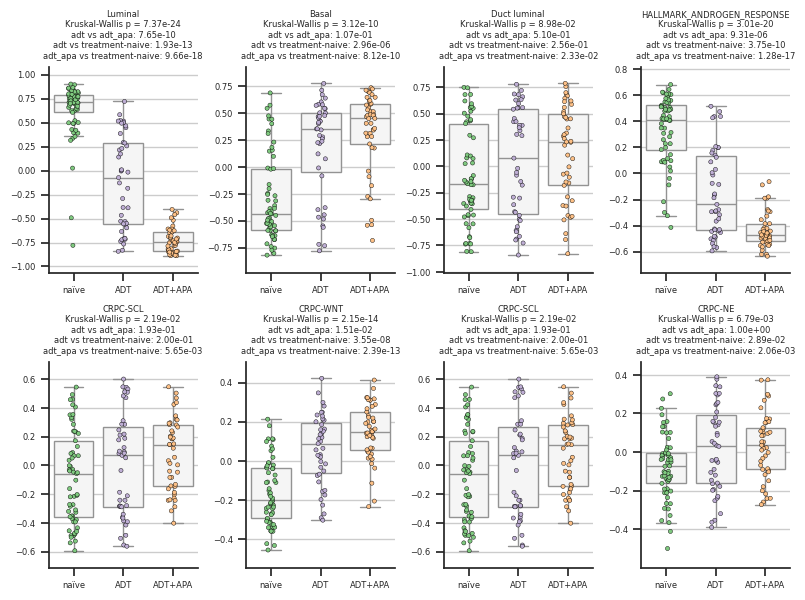

In [39]:

sns.set_theme(style='white', palette = 'Accent' , font_scale=0.55,rc={
    'xtick.bottom': True,
    'ytick.left': True})

modules = [
    'Luminal', 'Basal', 'Duct luminal', 'HALLMARK_ANDROGEN_RESPONSE',#'CRPC-AR',
    'CRPC-SCL', 'CRPC-WNT','CRPC-SCL','CRPC-NE'
]

cat = 'TRT_GROUP'

num_modules = len(modules)
num_cols = 4
num_rows = int(np.ceil(num_modules / num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 3))

for idx, signature in enumerate(modules):
    row = idx // num_cols
    col = idx % num_cols
    ax = axs[row, col]

    sns.boxplot(data=dat, x=cat, y=signature, color='whitesmoke', fliersize=0, ax=ax)
    sns.stripplot(data=dat, x=cat, y=signature, hue=cat, s=3, edgecolor='black', linewidth=0.3, legend=False, ax=ax)

    # Kruskal-Wallis test
    groups = [group[signature].dropna().values for name, group in dat.groupby(cat)]
    stat, pval = kruskal(*groups)

    # Mann-Whitney U pairwise comparisons
    group_names = dat[cat].unique()
    mw_pvals = []
    for g1, g2 in combinations(group_names, 2):
        data1 = dat[dat[cat] == g1][signature].dropna()
        data2 = dat[dat[cat] == g2][signature].dropna()
        if len(data1) > 0 and len(data2) > 0:
            _, mw_pval = mannwhitneyu(data1, data2, alternative='two-sided')
            mw_pvals.append(f"{g1} vs {g2}: {mw_pval:.2e}")

    ax.set_xlabel('')
    ax.spines[['top','right']].set_visible(False)
    ax.set_ylim(dat[signature].min() * 1.2, dat[signature].max() * 1.2)

    mw_text = "\n".join(mw_pvals)
    ax.set_title(f'{signature}\nKruskal-Wallis p = {pval:.2e}\n{mw_text}', fontsize=6)
    #ax.set_title(f'{signature}', fontsize=6)
    ax.set_ylabel('')
    ax.set_xticklabels(['naïve', 'ADT', 'ADT+APA'])

    ax.grid(axis='y')
plt.tight_layout()
plt.savefig('plots/arneo_signature_boxplots.pdf')
plt.show()


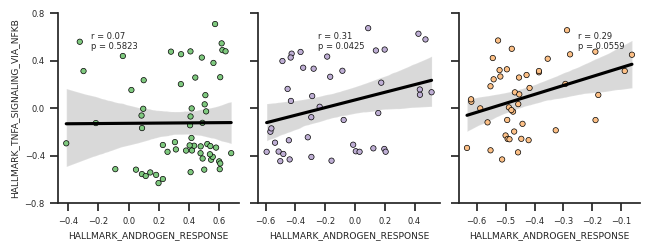

In [5]:
sns.set_theme(style='white', palette = 'Accent' , font_scale=0.55,rc={
    'xtick.bottom': True,
    'ytick.left': True})

sig1 = 'HALLMARK_ANDROGEN_RESPONSE'#'Basal_B1_Basal-ESR1'#'d2_dLum-KRT4' #'B1_Basal-ESR1'#
sig2 = 'HALLMARK_TNFA_SIGNALING_VIA_NFKB'#'HALLMARK_TNFA_SIGNALING_VIA_NFKB'#'Ductal luminal'#'d1_dLum-Club'#'IL1B MDSCs'#'d1_dLum-Club'

fig,axs = plt.subplots(1,3,figsize=(6.5,2.5),sharey=True)

for i,grp in enumerate(['treatment-naive','adt','adt_apa']):

    ax = axs[i]
    df = arneo_scoring_data[arneo_scoring_data['TRT_GROUP'] == grp].copy()

    stat, pval = spearmanr(df[sig1],df[sig2])

    sns.regplot(df,
                    x = sig1,
                    y= sig2,
                    scatter=False,
                    color='black',
                    ax=ax
                    )

    sns.scatterplot(df,
                    x = sig1,
                    y= sig2,
                    edgecolor='black',
                    hue = 'TRT_GROUP',
                    linewidth=0.5,
                    s = 15,
                    legend=None,
                    ax=ax
                    )

    ax.set_yticks([-0.8,-0.4,0,0.4,0.8])
    ax.text(s=f'r = {stat:.2f}\np = {pval:.4f}', x = -0.25,y = 0.5, size=6)
    ax.spines[['top','right']].set_visible(False)

    if i > 0:
        ax.set_ylabel('')


plt.tight_layout()
plt.savefig('/home/ak431480/plots/aa_regplot_signatures_arneo.pdf')
plt.show()

In [6]:
sns.set_theme(style='white',font_scale=0.8,palette='Accent')
#include_categories = ['adt_apa']
include_categories = ['treatment-naive','adt','adt_apa']

overlap = dat[dat['TRT_GROUP'].isin(include_categories)].index.intersection(dat.index)

x_expr = rnaseq_data.copy()
# Transpose the DataFrame so that rows become samples and columns become features (genes)
x_expr_transposed = x_expr.T

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_expr_transposed)

# Create a DataFrame for the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=x_expr_transposed.index)

modules = ['TRT_GROUP','Luminal','Duct luminal','Basal','JAK_STAT_FGFR','TISS']
#modules = ['TRT_GROUP','BPECT Luminal Identity','BPECT Club Identity','BPECT Basal Identity','BPECT Hillock Identity']

# Plot the first two principal components
num_modules = len(modules)
num_cols = 3
num_rows = int(np.ceil(num_modules / num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))

for idx, hue_var in enumerate(modules):
    row = idx // num_cols
    col = idx % num_cols
    ax = axs[row, col]
    if dat[hue_var].dtype.name == 'category':
        sns.scatterplot(pca_df,x = 'PC1',y='PC2',s=60,hue=dat[hue_var],ax=ax, edgecolor='black',linewidth=0.5)
    else:
        sns.scatterplot(pca_df,x = 'PC1',y='PC2',s=60,c=dat[hue_var],ax=ax, cmap= 'Reds', edgecolor='black',linewidth=0.5)
    ax.set_title(f'{hue_var} GSVA score')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines[['top','right']].set_visible(False)
    #plt.grid(True)
plt.tight_layout()
plt.clf()
#plt.show()


<Figure size 1200x800 with 0 Axes>

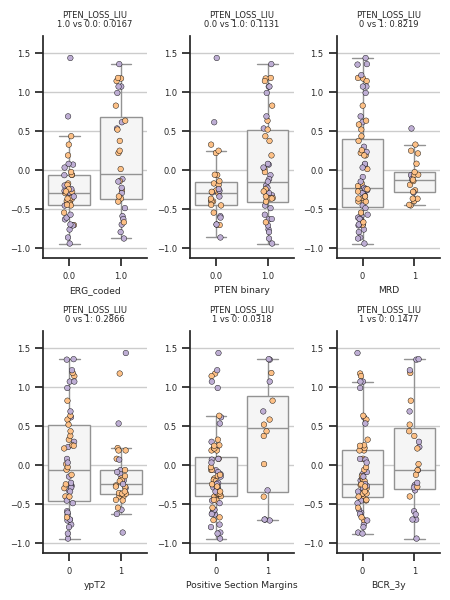

In [11]:
valid_cat = ['adt','adt_apa'] # 'adt',
plot_data = dat_with_clinical[dat_with_clinical['TRT_GROUP'].isin(valid_cat)].copy()
#plot_data = plot_data[plot_data['ERG_coded'] == 1].copy()

sns.set_theme(style='white', palette = 'Accent' , font_scale=0.55,rc={
    'xtick.bottom': True,
    'ytick.left': True})

signature = 'PTEN_LOSS_LIU'#'PSA at Biopsy'#'HALLMARK_TNFA_SIGNALING_VIA_NFKB'#'Duct luminal'#'TISS'
categories = ['ERG_coded','PTEN binary','MRD','ypT2','Positive Section Margins','BCR_3y']


#num_modules = len(modules)
num_cols = 3
num_rows = int(np.ceil(4 / num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 1.5, num_rows * 3))

for idx, cat in enumerate(categories):
    row = idx // num_cols
    col = idx % num_cols
    ax = axs[row, col]

    sns.boxplot(data=plot_data, x=cat, y=signature,color='whitesmoke', fliersize=0, ax=ax)
    sns.stripplot(data=plot_data, x=cat, y=signature, hue='TRT_GROUP', s=4, edgecolor='black', linewidth=0.3, legend=False, ax=ax)


    # Mann-Whitney U pairwise comparisons
    group_names = plot_data[cat].unique()
    mw_pvals = []
    for g1, g2 in combinations(group_names, 2):
        data1 = plot_data[plot_data[cat] == g1][signature].dropna()
        data2 = plot_data[plot_data[cat] == g2][signature].dropna()
        if len(data1) > 0 and len(data2) > 0:
            _, mw_pval = mannwhitneyu(data1, data2, alternative='two-sided')
            mw_pvals.append(f"{g1} vs {g2}: {mw_pval:.4f}")

    #ax.set_xlabel('')
    ax.spines[['top','right']].set_visible(False)
    ax.set_ylim(plot_data[signature].min() * 1.2, plot_data[signature].max() * 1.2)

    mw_text = "\n".join(mw_pvals)
    ax.set_title(f'{signature}\n{mw_text}', fontsize=6)
    #ax.set_title(f'{signature}', fontsize=6)
    ax.set_ylabel('')
    #ax.set_xticklabels(['naïve', 'ADT', 'ADT+APA'])

    ax.grid(axis='y')
plt.tight_layout()
#plt.savefig('plots/aa_arneo_signature_boxplots.pdf')
plt.show()


In [35]:
plot_data

,B1_Basal-ESR1,B2_Basal,B3_Basal-GPRC5A,B4_Basal,B5_Basal-VCAN,B6_Basal-IC1,BPECT Basal Identity,BPECT Club Identity,BPECT Hillock Identity,BPECT Luminal Identity,...,BCR_3y,BCR_FU,Time between RP and BCR,ERG_coded,PSMA_coded,Ki67_coded,GR_coded,PTEN binary,P53_coded,RCB_ml
ARN075,-0.052499,-0.302404,0.562663,-0.070544,0.369831,-0.010274,0.166017,0.256425,0.313396,0.527239,...,0,0,47,1.0,0.0,0.0,0.0,1.0,1.0,0.3000
ARN002,-0.187667,-0.066996,-0.130986,-0.694897,-0.111251,-0.268686,-0.432171,-0.472004,-0.347063,-0.572818,...,0,0,67,NaN,NaN,NaN,NaN,NaN,NaN,0.4500
ARN024,-0.193001,0.103529,-0.074240,-0.428272,0.528236,-0.306947,-0.034719,0.002261,-0.050715,-0.583006,...,0,0,50,0.0,1.0,0.0,1.0,0.0,0.0,1.2000
ARN028,0.218312,-0.172227,-0.341232,-0.511499,0.336680,-0.049426,-0.315848,-0.269778,-0.354163,0.453297,...,1,1,29,1.0,1.0,0.0,0.0,1.0,0.0,1.3500
ARN034,-0.497883,-0.055281,-0.360504,-0.278787,0.216097,-0.044133,-0.228399,-0.108041,-0.009619,0.054721,...,0,0,46,1.0,1.0,0.0,0.0,1.0,0.0,0.5200
ARN036,0.500792,0.458880,-0.084261,-0.197100,0.380391,0.292569,0.230884,0.085484,0.069027,-0.048590,...,0,1,42,NaN,NaN,NaN,NaN,NaN,NaN,1.4700
ARN045,-0.214427,0.502837,0.522346,0.389804,0.052602,0.128613,0.247555,0.470603,0.295668,-0.417786,...,0,0,53,1.0,0.0,0.0,0.0,0.0,0.0,0.3600
ARN047,0.526881,0.203176,-0.088348,-0.642205,0.697003,-0.620656,0.023644,-0.434985,-0.333895,0.435828,...,0,0,54,0.0,1.0,0.0,0.0,0.0,0.0,0.1500
ARN051,0.128788,0.048312,-0.474338,0.284263,0.471289,0.428072,0.219387,-0.383345,-0.394668,0.522938,...,0,1,45,0.0,0.0,1.0,1.0,0.0,1.0,0.0800
ARN014,0.291109,0.588250,0.214942,-0.548900,0.022417,0.214045,0.259861,-0.454479,-0.378723,-0.645277,...,1,1,4,1.0,1.0,0.0,0.0,1.0,1.0,2.9600


### Differential gene expression between two set groups

In [8]:
gene_annot = pd.read_csv('./data/labrecque_2019/Human.GRCh38.p13.annot.tsv',sep='\t')
protein_coding_genes = list(set(gene_annot[gene_annot['GeneType'] == 'protein-coding']['Symbol']))

arneo_clinical['PTEN_P53_double'] = 0
arneo_clinical.loc[((arneo_clinical['PTEN binary'] == 1) & (dat_with_clinical['P53_coded'] == 1)),'PTEN_P53_double'] = 1

/tmp/ipykernel_57762/3802162905.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_annot = pd.read_csv('./data/labrecque_2019/Human.GRCh38.p13.annot.tsv',sep='\t')


In [9]:
## Differential expression analysis

neg_samples = arneo_clinical[arneo_clinical['PTEN_P53_double'] == 0].index.tolist()
other_samples = arneo_clinical[arneo_clinical['PTEN_P53_double'] == 1].index.tolist()

# Extract sub-dataframes once
df = rnaseq_data.copy()
df = df[df.index.isin(protein_coding_genes)]
df = df[~(df.index.duplicated())]

neg_samples = [c for c in neg_samples if c in df.columns.tolist()]
other_samples = [c for c in other_samples if c in df.columns.tolist()]

neg_df = df[neg_samples]
other_df = df[other_samples]

# Precompute medians
neg_medians = neg_df.median(axis=1) + 1e-4
other_medians = other_df.median(axis=1) + 1e-4

# Log2 fold-change (vectorized)
log2fc = np.log2(neg_medians / other_medians)

# Compute p-values (still per gene, ranksums has no vectorized API)
pvals = [
    ranksums(neg_df.loc[g], other_df.loc[g]).pvalue
    for g in df.index.tolist()
]

# Build results dataframe
deg_results_df = pd.DataFrame({
    "gene": df.index,
    "log2fc": log2fc.values,
    "pval": pvals
})

# FDR correction
deg_results_df["fdr"] = multipletests(deg_results_df["pval"], method="fdr_bh")[1]
deg_results_df = deg_results_df.sort_values('fdr',ascending=True).reset_index(drop=True)

upregulated_genes_df = deg_results_df[((deg_results_df['log2fc'] >=1) & (deg_results_df['fdr'] < 0.05))]

upregulated_genes_df[:30]

,gene,log2fc,pval,fdr


### Find associations between AR activity and tumor content

In [13]:
# Only score for the treated samples for which there is ATAC-seq data
arneo_atac_samples = pd.read_csv('/home/ak431480/arneo_atac_seq_samples.tsv',sep='\t',header=None).rename(columns={0:'sample'})

# Filter by treated
overlap = rnaseq_data.columns.intersection(metadata[metadata['TRT_GROUP'] != 'treatment-naive'].index)
#overlap = rnaseq_data.columns.intersection(metadata[~(metadata['TRT_GROUP'].isin(['treatment-naive','adt']))].index)

score_names = list(gene_modules_dict.keys())

# Log2 transform
gsva_res = gp.gsva(data=np.log2(rnaseq_data[overlap]),gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')
gsva_res_df = gsva_res_df.set_index('Sample Identifier').astype('float')

gsva_res_df = gsva_res_df.loc[overlap]

if (gsva_res_df.index == metadata.loc[overlap].index).all():
    dat_treated = pd.concat([gsva_res_df,metadata.loc[overlap]], axis=1)

dat_treated_with_clinical = pd.merge(dat_treated,arneo_clinical,left_index=True,right_index=True)

dat_treated_with_clinical['ypT stage'] = pd.Categorical(dat_treated_with_clinical['ypT2'].map({1:'ypT2',0:'ypT3/4'}),categories=['ypT2','ypT3/4'])

#dat_treated_with_clinical[score_names] = regress_out_signature(dat_treated_with_clinical[score_names  + ['RCB_ml']],'Luminal')

/home/ak431480/.local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
2025-09-16 11:23:02,363 [WARNING] Found duplicated gene names, values averaged by gene names!
2025-09-16 11:23:02,481 [WARNING] Input gene rankings contains inf values!


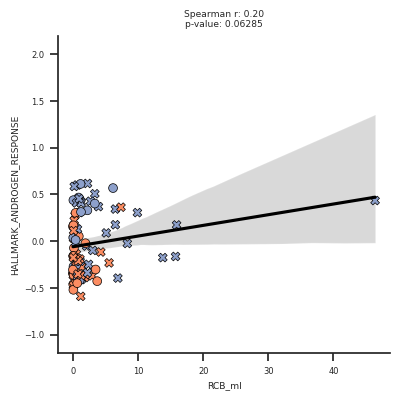

In [14]:
pal = sns.color_palette('Set2')
pal = sns.color_palette([pal[2],pal[1]])
sns.set_theme(style='white', palette=pal, font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})

sig1 = 'RCB_ml'
sig2 = 'HALLMARK_ANDROGEN_RESPONSE'#'HALLMARK_TNFA_SIGNALING_VIA_NFKB'#'HALLMARK_ANDROGEN_RESPONSE'
style_var = 'ypT stage'#'BCR_FU'

df = dat_treated_with_clinical.copy()

df[sig1] = df[sig1].astype('float64')
df[sig2] = df[sig2].astype('float64')
df = df[~(df[sig1].isna())]

fig, ax = plt.subplots(figsize=(4,4))

stat, pval = spearmanr(df[sig1],df[sig2])

sns.regplot(df,
                x = sig1,
                y= sig2,
                scatter=False,
                color='black',
                ax=ax
                )

sns.scatterplot(df,
                x = sig1,
                y= sig2,
                edgecolor='black',
                linewidth=0.5,
                s = 40,
                style=style_var,
                legend=None,
                hue='TRT_GROUP',
                ax=ax
                )

ax.spines[['right','top']].set_visible(False)
ax.set_ylim(-1.2,2.2)

ax.set_title(f'Spearman r: {stat:.2f}\np-value: {pval:.5f}')

plt.tight_layout()
plt.savefig('/home/ak431480/plots/regplot.pdf')

plt.show()

In [16]:
style_var = 'ypT stage'
#style_var = 'Randomisation'
#df_small = df[df['MRD'] == 0].copy()
df_small = df.copy()
median = df_small[sig2].median() 
#median = 0
df_small[f'{sig2}_binary'] = (df_small[sig2] > median).astype(int)

# Check if MRD is enriched in low tc tumors (requires not filtering by MRD above!!)
crosstab_df = pd.crosstab(df_small[f'{sig2}_binary'],df_small[style_var])

# Map binary_scores
crosstab_df.index = crosstab_df.index.map({1:'high',0:'low'})
#crosstab_df.columns = crosstab_df.columns.map({1:'ADT+APA',0:'ADT'})
#crosstab_df.columns = crosstab_df.columns.map({1:'yes',0:'no'})

# Order columns
crosstab_df = crosstab_df.loc[['high','low'],['ypT3/4','ypT2']]
#crosstab_df = crosstab_df.loc[['high','low'],['yes','no']]
#crosstab_df = crosstab_df.loc[['low','high'],['ADT+APA','ADT']]

oddsr, pval = fisher_exact(crosstab_df)
print(f'{sig2} score median: {median:.2f}')
print(f'OR = {oddsr:.1f}, p = {pval:.1e}')
crosstab_df



HALLMARK_ANDROGEN_RESPONSE score median: -0.13
OR = 1.6, p = 3.8e-01


ypT stage,ypT3/4,ypT2
HALLMARK_ANDROGEN_RESPONSE_binary,,
high,29,15
low,24,20


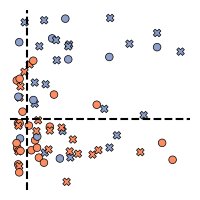

In [17]:
# Limit to just ATAC-seq samples
#overlap = overlap[overlap.isin(arneo_atac_samples['sample'])]
#plot_df = df.loc[overlap].copy()
plot_df = df.copy()

fig, ax = plt.subplots(figsize=(2,2))

sns.scatterplot(plot_df,
                x = sig1,
                y = sig2,
                edgecolor='black',
                linewidth=0.5,
                s = 30,
                style=style_var,
                legend=None,
                hue='TRT_GROUP',
                ax=ax
                )

ax.spines[['right','top']].set_visible(False)
ax.axhline(y=median,linestyle='--',c='k')
ax.axvline(x = 0.25,linestyle='--',c='k') # MRD threhold

ax.set_xticks([0,1,2,3,4])
ax.set_yticks([-0.6,-0.3,0,0.3,0.6])

ax.axis('off')
ax.set_xlim(-0.15,4.15)
#ax.set_ylim(-1,1)

plt.tight_layout()
plt.savefig('/home/ak431480/plots/regplot.pdf')

plt.show()

In [18]:
#df_small = df[df['MRD'] == 1].copy()
df_small = df.copy()
df_small[f'{sig2}_binary'] = (df_small[sig2] > median).astype(int)
df_small[f'{sig2}_binary'] = df_small[f'{sig2}_binary'].map({1:'high',0:'low'})

# Check if MRD is enriched in low tc tumors (requires not filtering by MRD above!!)
crosstab_df = pd.crosstab(df_small[f'{sig2}_binary'],df_small['ypT2'])
crosstab_df.columns = crosstab_df.columns.map({1:'ypT2',0:'ypT3-4'})
crosstab_df = crosstab_df.loc[['high','low'],['ypT3-4','ypT2']]

oddsr, pval = fisher_exact(crosstab_df)
print(f'{sig2} score median: {median:.2f}')
print(f'OR = {oddsr:.1f}, p = {pval:.3f}')
crosstab_df



HALLMARK_ANDROGEN_RESPONSE score median: -0.13
OR = 1.6, p = 0.384


ypT2,ypT3-4,ypT2
HALLMARK_ANDROGEN_RESPONSE_binary,,
high,29,15
low,24,20


In [6]:
sns.set_theme(style='white', palette=pal, font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})


sig = 'TISS'#,'JAK_STAT_FGFR'#'HALLMARK_TNFA_SIGNALING_VIA_NFKB'#'TISS'HALLMARK_IL6_JAK_STAT3_SIGNALING
var = f'{sig2}_binary'

fig, axs = plt.subplots(1,2,figsize=(5,4),sharey=True)

for i,stage in enumerate(['ypT2','ypT3/4']):
#for i,stage in enumerate([0,1]):

    #plot_df = df_small[df_small['BCR_FU'] == stage]
    plot_df = df_small[df_small['ypT stage'] == stage]
    plot_df[var] = pd.Categorical(plot_df[var],categories=['high','low'])

    ax = axs[i]
    sns.stripplot(plot_df,
                x = var,
                y = sig,
                hue = 'TRT_GROUP',
                edgecolor='black',
                linewidth = 0.5,
                s = 6,
                legend = False,
                ax = ax
                )


    sns.boxplot(data=plot_df,
                x=var,
                y=sig,
                color='whitesmoke',
                showfliers=False,
                linewidth=1,
                ax=ax)

    #ax.set_ylim(-0.65,0.75)

    ax.spines[['right','top']].set_visible(False)

    stat, pval = ranksums(plot_df[plot_df[var] == 'low'][sig], plot_df[plot_df[var] == 'high'][sig])
    #ax.set_ylim(-0.65,16)
    ax.set_title(f'{stage}\np = {pval:.4f}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.grid(axis='y')

plt.tight_layout()
plt.show()


NameError: name 'pal' is not defined

In [49]:
crosstab_df = pd.crosstab(df_small[f'{sig2}_binary'],
            df_small['ypT stage']
    )
fisher_exact(crosstab_df)
crosstab_df

ypT stage,ypT2,ypT3/4
HALLMARK_ANDROGEN_RESPONSE_binary,,
high,15,29
low,20,24


<Axes: xlabel='HALLMARK_ANDROGEN_RESPONSE', ylabel='Density'>

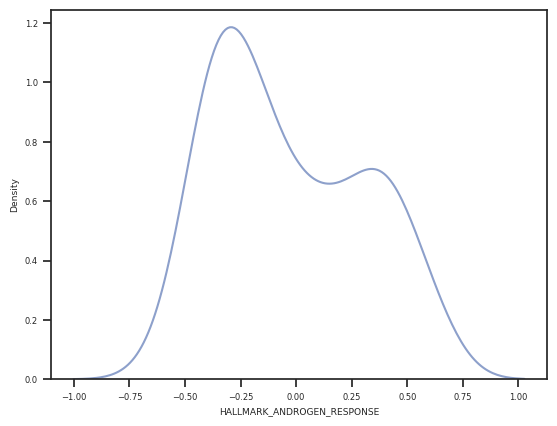

In [50]:
#df_kde = df_small[df_small['Randomisation'] == 0]
df_kde = df_small.copy()
sns.kdeplot(df_kde,x=sig2)

### Run differential expression analysis between low androgen signaling 

In [56]:
samples1 = df_small[(
    (df_small[var] == 'low') &
    (df_small['ypT stage'] == 'ypT3/4')
    )].index.tolist()

samples2 = df_small[(
    (df_small[var] == 'high') &
    (df_small['ypT stage'] == 'ypT3/4')
    )].index.tolist()

In [57]:
rnaseq_data_df = rnaseq_data[rnaseq_data.index.isin(protein_coding_genes)]

# Split expression data by group
high_expr = rnaseq_data_df[samples1]
low_expr  = rnaseq_data_df[samples2]

results = []

for gene, row in rnaseq_data_df.iterrows():
    # Wilcoxon rank-sum test (independent samples)
    stat, pval = ranksums(row[samples1], row[samples2])

    # log2 fold change: comparison (low_ar) minus baseline (high_ar)
    mean_low  = row[samples_low_ar].mean()
    mean_high = row[samples_high_ar].mean()
    # add small constant to avoid log of zero
    logfc = np.log2((mean_low + 1e-6) / (mean_high + 1e-6))

    results.append((gene, logfc, pval))

# Create DataFrame
res_df = pd.DataFrame(results, columns=['gene', 'log2FC', 'pval'])

# Multiple-testing correction (FDR Benjamini–Hochberg)
res_df['FDR'] = multipletests(res_df['pval'], method='fdr_bh')[1]

# Sort: genes higher in comparison (low_ar) first
res_df = res_df.sort_values(by='log2FC', ascending=False).reset_index(drop=True)

print(res_df.head())

     gene     log2FC      pval       FDR
0  XAGE1A  19.690726  0.714137  0.855162
1   PAGE1  16.470950  0.795563  0.901340
2   CSAG1  16.457653  0.145314  0.326190
3    ETDC  16.234150  0.727512  0.863059
4  XAGE1B  16.129035  0.401008  0.618049


In [52]:
res_df[((res_df['FDR'] < 0.05) & (res_df['log2FC'] >= 0.5))]

,gene,log2FC,pval,FDR


## Labrecque et al. mCRPC bulk data

In [2]:
metastasis_mapping = {
    #     
    "CRPC lung metastasis": "lung metastasis",
    
    #
    "CRPC liver metastasis": "liver metastasis",
 
    # Lymph node metastasis
    "CRPC lymph node (LN) metastasis": "lymph node metastasis",

    # Bone metastasis
    "CRPC bone metastasis": "bone metastasis",

    # Soft tissue metastasis
    "CRPC adrenal metastasis": "soft tissue metastasis",
    "CRPC retroperitoneal metastasis": "soft tissue metastasis",
    "CRPC diaphram metastasis": "soft tissue metastasis",
    "CRPC renal metastasis": "soft tissue metastasis",
    "CRPC bladder metastasis": "soft tissue metastasis",
    "CRPC pelvic mass metastasis": "soft tissue metastasis",
    "CRPC pleural metastasis": "soft tissue metastasis",
    "CRPC left posterior metastasis": "soft tissue metastasis",
    "CRPC spleen metastasis": "soft tissue metastasis",
    "CRPC periaortic metastasis": "soft tissue metastasis",
    "CRPC periaortic diaphragm metastasis": "soft tissue metastasis",
    "CRPC parietal diaphragm metastasis": "soft tissue metastasis",
    "CRPC tail of pancreas metastasis": "soft tissue metastasis",
    "CRPC pancreas metastasis": "soft tissue metastasis",
    "CRPC perirectal omental metastasis": "soft tissue metastasis",
    "CRPC pelvic peritoneal metastasis": "soft tissue metastasis",

}

# Match gene names to those in signatures
gene_alias_dict = {
    'ACP3' : 'ACPP',
    'CCN1' : 'CYR61',
    'SHLD2' : 'FAM35A',
    'TENT5C': 'FAM46C',
    'TAFA5' : 'FAM19A5',
    'GET3' : 'ASNA1',
}


In [3]:
# Download data and format metadata
dat = pd.read_csv('./data/labrecque_2019/GSE126078_norm_counts_TPM_GRCh38.p13_NCBI.tsv',sep='\t',index_col=0) # NCBI-generated TPM matrix from https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE126078

# Replace Entrez IDs with gene symbols
gene_annot = pd.read_csv('./data/labrecque_2019/Human.GRCh38.p13.annot.tsv',sep='\t')
gene_mapping_dict = gene_annot.set_index('GeneID')['Symbol'].to_dict()
dat.index = dat.index.map(gene_mapping_dict)

# Normalize by protein coding
protein_coding_genes = list(set(gene_annot[gene_annot['GeneType'] == 'protein-coding']['Symbol']))
dat = dat[dat.index.isin(protein_coding_genes)]
dat = dat.rename(index=gene_alias_dict)

meta = pd.read_csv('./data/labrecque_2019/GSE126078_series_matrix.txt',sep='\t',skiprows=51,index_col=0)
# Extract relevant columns
meta = meta.T[['!Sample_geo_accession','!Sample_characteristics_ch1','!Sample_source_name_ch1']]

# Drop unused columns
meta = pd.DataFrame(meta.iloc[:,[0,4,5,7]])
column_names = ['GEO_ID','patient','molecular_phenotype','metastatic_site']
meta.columns = column_names


# Map the sample names onto columns
geo_to_sample_dict = meta.reset_index().set_index('GEO_ID')['index'].to_dict()
dat.columns = dat.columns.map(geo_to_sample_dict)

CRPC_only = True #### Adjust accordingly
if CRPC_only:
    meta = meta[meta.index.str.contains('CRPC')]
    dat = dat[meta.index.tolist()]
    meta['molecular_phenotype'] = pd.Categorical([s.split(': ')[1] for s in meta['molecular_phenotype']],categories=['ARpos_NEneg','ARpos_NEpos','ARneg_NEpos','ARlow_NEneg','ARneg_NEneg'])

# Drop the 'patient: ' prefix in the patient column
meta['patient'] = [p.split(' ')[1] for p in meta['patient']]

meta_index = meta.index.copy()
# Add the mutation metadata
mutation_metadata = pd.read_excel('/home/ak431480/labrecque_2019_mutation_data.xlsx')
cna_categories = ['amplification', 'cn_gain', 'cnv', 'none', 'monoallelic_loss','biallelic_loss','missing']
for c in mutation_metadata:
    if '_STATUS' in c:
        mutation_metadata[c] = pd.Categorical(mutation_metadata[c],categories = cna_categories)
        mutation_metadata[c] = mutation_metadata[c].cat.remove_unused_categories()

meta = pd.merge(meta,mutation_metadata,left_on='patient',right_on='patient',how='left')
meta[mutation_metadata.columns[1:]] = meta[mutation_metadata.columns[1:]].fillna('missing')

meta.index = meta_index.copy()

tpm = dat.copy()

# Remove overlaps
gene_modules_dict_mod = gene_modules_dict.copy()
gene_modules_dict_mod['HALLMARK_TNFA_SIGNALING_VIA_NFKB_modified'] = list(set(gene_modules_dict['HALLMARK_TNFA_SIGNALING_VIA_NFKB']).difference(set(gene_modules_dict['TISS'])))

gsva_res = gp.gsva(data=tpm,gene_sets=gene_modules_dict_mod,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

gsva_res_meta = pd.merge(meta,gsva_res_df, right_on='Sample Identifier',left_index=True)

gsva_res_meta['metastatic_site_simple'] = pd.Categorical(gsva_res_meta['metastatic_site'].map(metastasis_mapping),categories=['lung metastasis','liver metastasis','lymph node metastasis','bone metastasis','soft tissue metastasis',])



/tmp/ipykernel_156608/2009119264.py:5: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_annot = pd.read_csv('./data/labrecque_2019/Human.GRCh38.p13.annot.tsv',sep='\t')


/tmp/ipykernel_156608/639688225.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stat, p_val = kruskal(*plot_df[[var,sig]].groupby(var)[sig].apply(list))
/tmp/ipykernel_156608/639688225.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-30)


none vs monoallelic_loss: 0.0058 **
none vs biallelic_loss: 0.0000 ***
monoallelic_loss vs biallelic_loss: 0.09


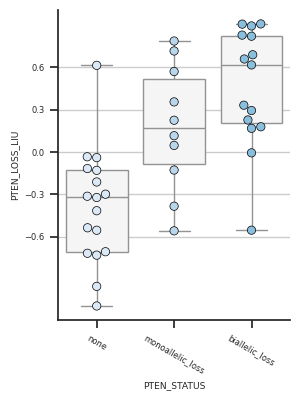

In [4]:
#plot_df = gsva_res_meta.copy()
plot_df = gsva_res_meta[~((gsva_res_meta == 'missing').any(axis=1))].reset_index(drop=True)
#plot_df = plot_df[plot_df['AR_STATUS'] == 'none']

sns.set_theme(style='white', palette='Blues', font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})

sig = 'PTEN_LOSS_LIU'
var = 'PTEN_STATUS'

plot_df[var] = pd.Categorical(plot_df[var])
plot_df['PTEN_LOSS_LIU'] = plot_df['PTEN_LOSS_UP'] - plot_df['PTEN_LOSS_DOWN']

# Only keep categories if they're present in 10% or more samples
val_counts = plot_df[var].value_counts()
valid_categories = val_counts[val_counts >= len(plot_df)*0.1].index.tolist()
plot_df = plot_df[plot_df[var].isin(valid_categories)]

plot_df[var] = plot_df[var].cat.remove_unused_categories()


#plot_df[var] = plot_df[var].cat.set_categories(plot_df[var].cat.categories[::-1])

stat, p_val = kruskal(*plot_df[[var,sig]].groupby(var)[sig].apply(list))

#fig, ax = plt.subplots(figsize=(1.8,2.5))
fig, ax = plt.subplots(figsize=(3,4))

sns.swarmplot(plot_df,
              x = var,
              y = sig,
              hue = var,
              edgecolor='black',
              linewidth = 0.5,
              s = 6,
              legend = False,
              ax = ax
              )


sns.boxplot(data=plot_df,
            x=var,
            y=sig,
            color='whitesmoke',
            showfliers=False,
            linewidth=1,
            ax=ax)

ax.spines[['right','top']].set_visible(False)

ax.set_yticks([-0.6,-0.3,0,0.3,0.6])
#ax.set_ylim(-0.65,0.85)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-30)
#ax.set_xticklabels([])
plt.grid(axis='y')

plt.tight_layout()

plt.savefig(f'/home/ak431480/plots/Labracque_et_al_{sig}_GSVA_score_by_{var}.pdf')
#plt.show()

for grp1, grp2 in list(combinations(plot_df[var].cat.categories,2)):
    stat, pval = ranksums(plot_df[plot_df[var] == grp1][sig],
                            plot_df[plot_df[var] == grp2][sig])

    if pval < 0.001:
        print(f'{grp1} vs {grp2}: {pval:.4f} ***')
    
    elif pval < 0.01:
        print(f'{grp1} vs {grp2}: {pval:.4f} **')
    
    elif pval < 0.05:
        print(f'{grp1} vs {grp2}: {pval:.4f} *')
    
    elif pval >= 0.05:
        print(f'{grp1} vs {grp2}: {pval:.2f}')


In [5]:
#plot_df[plot_df[var] == 'none'].sort_values(sig,ascending=False)
plot_df['metastatic_site'].value_counts()

metastatic_site
CRPC liver metastasis                   14
CRPC lymph node (LN) metastasis          9
CRPC lung metastasis                     6
CRPC adrenal metastasis                  3
CRPC bone metastasis                     3
CRPC bladder metastasis                  1
CRPC periaortic metastasis               1
CRPC periaortic diaphragm metastasis     1
CRPC tail of pancreas metastasis         1
CRPC pancreas metastasis                 1
CRPC perirectal omental metastasis       1
CRPC pelvic peritoneal metastasis        1
Name: count, dtype: int64

### Molecular phenotype – gene signature activity

/tmp/ipykernel_156608/538843647.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stat, p_val = kruskal(*gsva_res_meta[[var,sig]].groupby(var)[sig].apply(list))
/tmp/ipykernel_156608/538843647.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-30)


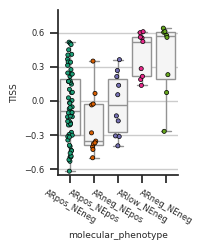

ARpos_NEneg vs ARpos_NEpos: 0.10
ARpos_NEneg vs ARneg_NEpos: 0.84
ARpos_NEneg vs ARlow_NEneg: 0.0002 ***
ARpos_NEneg vs ARneg_NEneg: 0.0022 **
ARpos_NEpos vs ARneg_NEpos: 0.09
ARpos_NEpos vs ARlow_NEneg: 0.0005 ***
ARpos_NEpos vs ARneg_NEneg: 0.0017 **
ARneg_NEpos vs ARlow_NEneg: 0.0043 **
ARneg_NEpos vs ARneg_NEneg: 0.0164 *
ARlow_NEneg vs ARneg_NEneg: 0.56


In [6]:
sns.set_theme(style='white', palette='Dark2', font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})

sig = 'TISS'
var = 'molecular_phenotype'
#var = 'molecular_phenotype_simple'

stat, p_val = kruskal(*gsva_res_meta[[var,sig]].groupby(var)[sig].apply(list))

fig, ax = plt.subplots(figsize=(2,2.5))

sns.stripplot(gsva_res_meta,
              x = var,
              y = sig,
              hue = var,
              edgecolor='black',
              linewidth = 0.5,
              s = 3,
              legend = False,
              ax = ax
              )


sns.boxplot(data=gsva_res_meta,
            x=var,
            y=sig,
            color='whitesmoke',
            showfliers=False,
            linewidth=1,
            ax=ax)

#ax.set_ylim(-0.65,0.8)

ax.spines[['right','top']].set_visible(False)

ax.set_yticks([-0.6,-0.3,0,0.3,0.6])
ax.set_ylim(-0.65,0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-30)
plt.grid(axis='y')

plt.tight_layout()

plt.savefig(f'/home/ak431480/plots/Labracque_et_al_{sig}_GSVA_score_by_{var}.pdf')
plt.show()

for grp1, grp2 in list(combinations(gsva_res_meta[var].cat.categories,2)):
    stat, pval = ranksums(gsva_res_meta[gsva_res_meta[var] == grp1][sig],
                            gsva_res_meta[gsva_res_meta[var] == grp2][sig])

    if pval < 0.001:
        print(f'{grp1} vs {grp2}: {pval:.4f} ***')
    
    elif pval < 0.01:
        print(f'{grp1} vs {grp2}: {pval:.4f} **')
    
    elif pval < 0.05:
        print(f'{grp1} vs {grp2}: {pval:.4f} *')
    
    elif pval >= 0.05:
        print(f'{grp1} vs {grp2}: {pval:.2f}')


### Differential gene expression analysis

In [7]:
neg_samples = meta[meta['molecular_phenotype'].isin(['ARlow_NEneg','ARneg_NEneg'])].index.tolist()
other_samples = meta[meta['molecular_phenotype'].isin(['ARpos_NEneg','ARpos_NEpos','ARpos_NEpos'])].index.tolist()
#hvgs = tpm.var(axis=1).sort_values(ascending=False)[:2000].index.tolist()
hvgs = tpm.index.tolist()

# Extract sub-dataframes once
df = tpm.loc[hvgs]
neg_df = df[neg_samples]
other_df = df[other_samples]

# Precompute medians
neg_medians = neg_df.median(axis=1) + 1e-4
other_medians = other_df.median(axis=1) + 1e-4

# Log2 fold-change (vectorized)
log2fc = np.log2(neg_medians / other_medians)

# Compute p-values (still per gene, ranksums has no vectorized API)
pvals = [
    ranksums(neg_df.loc[g], other_df.loc[g]).pvalue
    for g in hvgs
]

# Build results dataframe
deg_results_df = pd.DataFrame({
    "gene": hvgs,
    "log2fc": log2fc.values,
    "pval": pvals
})

# FDR correction
deg_results_df["fdr"] = multipletests(deg_results_df["pval"], method="fdr_bh")[1]
deg_results_df = deg_results_df.sort_values('fdr',ascending=True).reset_index(drop=True)

upregulated_genes_df = deg_results_df[((deg_results_df['log2fc'] >=1) & (deg_results_df['fdr'] < 0.05))]


In [35]:
upregulated_genes_df[upregulated_genes_df['gene'].str.contains('IL1')]

,gene,log2fc,pval,fdr
91,IL1R2,2.347752,0.000001,0.000245
303,IL1RL2,1.725648,0.000019,0.001208
505,IL18R1,1.588868,0.000058,0.002214
645,RAB3IL1,1.274668,0.000103,0.003011
734,IL15,1.211979,0.000133,0.003510
746,IL1RL1,3.787708,0.000139,0.003595
979,IL15RA,1.390383,0.000261,0.005126
1006,IL18RAP,2.105741,0.000283,0.005389
1580,IL18,1.590847,0.001032,0.012583
2152,IL1RN,1.834976,0.002593,0.023388


### Plot DNPC upregulated genes in ARNEO correlation plot

In [10]:
treated_samples = metadata[metadata['TRT_GROUP_SIMPLE'] == 'neoadjuvant-treated'].index.tolist()
arneo_rnaseq_data = rnaseq_data.loc[rnaseq_data.index.isin(tpm.index.tolist()),treated_samples]
arneo_scoring_data = arneo_scoring_data.loc[treated_samples]

results = []
sig = 'TISS'

valid_genes = [g for g in upregulated_genes_df['gene'].tolist() if g in arneo_rnaseq_data.index.tolist()]

for g in valid_genes:
    stat, pval = spearmanr(arneo_rnaseq_data.loc[g], arneo_scoring_data[sig])
    results.append({
        'Gene': g,
        'SpearmanR': stat,
        'P-value': pval
    })

results_df = pd.DataFrame(results)
results_df = results_df.dropna()
results_df['FDR'] = multipletests(results_df['P-value'], method='fdr_bh')[1]
results_df['FDR_binary'] = (results_df['FDR'] < 0.05).astype(int)
results_df['-log10FDR'] = -np.log10(results_df['FDR'])

results_df = results_df.sort_values('SpearmanR',ascending=False).reset_index(drop=True)

results_df = results_df[~(results_df['Gene'].isin(gene_modules_dict[sig]))].reset_index(drop=True)

/home/ak431480/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


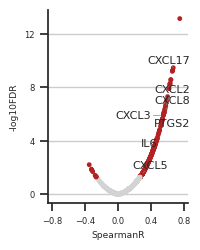

In [11]:
#genes = gene_modules_dict['JAK_STAT_FGFR']
genes = ['PTGS2','CXCL17','CXCL1','CXCL2','CXCL3','CXCL5','CXCL8','IL6']

top_genes = results_df[(results_df['FDR']<0.05) & (results_df['Gene'].isin(genes))]

sns.set_theme(style='white', palette=sns.color_palette(['lightgray', 'firebrick']), font_scale=0.55,
              rc={'xtick.bottom': True, 'ytick.left': True})

fig, ax = plt.subplots(figsize=(2, 2.5))

sns.scatterplot(data=results_df,
                x='SpearmanR',
                y='-log10FDR',
                hue='FDR_binary',
                edgecolor='black',
                linewidth=0,
                s=12,
                legend=None,
                ax=ax)

from adjustText import adjust_text

texts = []
for _, row in top_genes.iterrows():
    texts.append(ax.text(row['SpearmanR'], row['-log10FDR'], row['Gene'], fontsize=8, ha='right'))

ax.set_yticks([0,4,8,12])
ax.set_xticks([-0.8,-0.4,0,0.4,0.8])
ax.set_xlim(-0.85,0.85)
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))


ax.spines[['top', 'right']].set_visible(False)
plt.grid(axis='y')

plt.tight_layout()

plt.savefig('/home/ak431480/plots/ARNEO_correlating_chemokines.pdf')
plt.show()


In [26]:
len(results_df)

1297

In [25]:
results_df[results_df['Gene'].str.contains('IL13')]

,Gene,SpearmanR,P-value,FDR,FDR_binary,-log10FDR


### Correlation plot

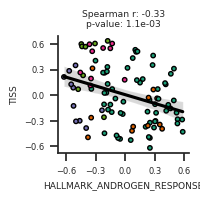

In [13]:
sns.set_theme(style='white', palette='Dark2', font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})

sig1 = 'HALLMARK_ANDROGEN_RESPONSE'
sig2 = 'TISS'

df = pd.merge(meta,gsva_res_df, right_on='Sample Identifier',left_index=True)

df[sig1] = df[sig1].astype('float64')
df[sig2] = df[sig2].astype('float64')

fig, ax = plt.subplots(figsize=(2,2))

stat, pval = spearmanr(df[sig1],df[sig2])

sns.regplot(df,
                x = sig1,
                y= sig2,
                scatter=False,
                color='black',
                ax=ax
                )

sns.scatterplot(df,
                x = sig1,
                y= sig2,
                edgecolor='black',
                hue = 'molecular_phenotype',
                linewidth=1,
                s = 10,
                legend=None,
                ax=ax
                )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([-0.6,-0.3,0,0.3,0.6])
ax.set_yticks([-0.6,-0.3,0,0.3,0.6])

ax.set_title(f'Spearman r: {stat:.2f}\np-value: {pval:.1e}')

plt.tight_layout()
plt.savefig('./plots/tmp/regplot.pdf')

plt.show()

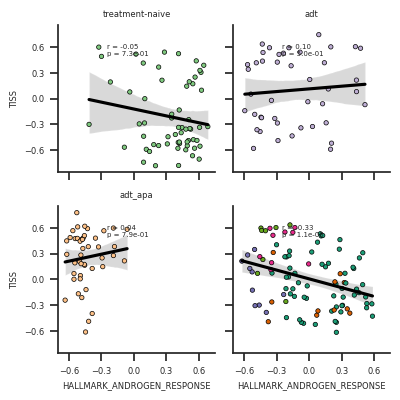

In [6]:

sns.set_theme(style='white', palette='Accent', font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})

sig1 = 'HALLMARK_ANDROGEN_RESPONSE'
sig2 = 'TISS'#'HALLMARK_IL6_JAK_STAT3_SIGNALING'

# --- 2x2 layout (4 inches x 4 inches total) ---
fig, axs = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True)
axs = axs.flatten()

# ----------------------------
# Panels A–C: By TRT_GROUP
# ----------------------------
groups = ['treatment-naive', 'adt', 'adt_apa']
for i, grp in enumerate(groups):
    ax = axs[i]
    df_sub = arneo_scoring_data[arneo_scoring_data['TRT_GROUP'] == grp].copy()
    stat, pval = spearmanr(df_sub[sig1], df_sub[sig2])

    sns.regplot(df_sub,
                x=sig1, y=sig2,
                scatter=False,
                color='black',
                ax=ax)

    sns.scatterplot(df_sub,
                    x=sig1, y=sig2,
                    edgecolor='black',
                    hue='TRT_GROUP',
                    linewidth=0.5,
                    s=10,
                    legend=None,
                    ax=ax)

    ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.text(s=f'r = {stat:.2f}\np = {pval:.1e}', x=-0.25, y=0.5, size=5)
    ax.set_title(grp, fontsize=6)
    ax.spines[['top','right']].set_visible(False)

# -------------------
# Panel D: All samples
# -------------------

sns.set_theme(style='white', palette='Dark2', font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})


ax = axs[3]
df = pd.merge(meta, gsva_res_df, right_on='Sample Identifier', left_index=True)
df[sig1] = df[sig1].astype('float64')
df[sig2] = df[sig2].astype('float64')

stat, pval = spearmanr(df[sig1], df[sig2])

sns.regplot(df,
            x=sig1, y=sig2,
            scatter=False,
            color='black',
            ax=ax)

sns.scatterplot(df,
                x=sig1, y=sig2,
                edgecolor='black',
                hue='molecular_phenotype',
                #color = 'orange',
                linewidth=0.5,
                s=10,
                legend=None,
                ax=ax)

ax.spines[['top','right']].set_visible(False)
ax.set_xticks([-0.6, -0.3, 0, 0.3, 0.6])
ax.set_yticks([-0.6, -0.3, 0, 0.3, 0.6])
ax.text(s=f'r = {stat:.2f}\np = {pval:.1e}', x=-0.25, y=0.5, size=5)

# -------------------
# Axes labels
# -------------------
for i, ax in enumerate(axs):
    if i % 2 == 0:  # left column
        ax.set_ylabel(sig2, fontsize=6)
    else:
        ax.set_ylabel("")
    if i >= 2:      # bottom row
        ax.set_xlabel(sig1, fontsize=6)
    else:
        ax.set_xlabel("")

plt.tight_layout()
plt.savefig('/home/ak431480/plots/combined_2x2_regplots_ordered.pdf')
plt.show()


In [ ]:
sns.set_theme(style='white', palette = 'Accent' , font_scale=0.55,rc={
    'xtick.bottom': True,
    'ytick.left': True})

sig1 = 'TISS'#'Basal_B1_Basal-ESR1'#'d2_dLum-KRT4' #'B1_Basal-ESR1'#
sig2 = 'HALLMARK_TNFA_SIGNALING_VIA_NFKB'#'HALLMARK_TNFA_SIGNALING_VIA_NFKB'#'Ductal luminal'#'d1_dLum-Club'#'IL1B MDSCs'#'d1_dLum-Club'

fig,axs = plt.subplots(1,3,figsize=(6,2),sharey=True,sharex=True)

for i,grp in enumerate(['treatment-naive','adt','adt_apa']):

    ax = axs[i]
    df = arneo_scoring_data[arneo_scoring_data['TRT_GROUP'] == grp].copy()

    stat, pval = spearmanr(df[sig1],df[sig2])

    sns.regplot(df,
                    x = sig1,
                    y= sig2,
                    scatter=False,
                    color='black',
                    ax=ax
                    )

    sns.scatterplot(df,
                    x = sig1,
                    y= sig2,
                    edgecolor='black',
                    hue = 'TRT_GROUP',
                    linewidth=0.5,
                    s = 15,
                    legend=None,
                    ax=ax
                    )

    ax.set_xticks([-0.8,-0.4,0,0.4,0.8])
    ax.set_yticks([-0.8,-0.4,0,0.4,0.8])
    ax.text(s=f'r = {stat:.2f}\np = {pval:.1e}', x = -0.25,y = 0.5, size=6)
    ax.spines[['top','right']].set_visible(False)
    ax.set_ylabel('HALLMARK_TNFa')

plt.tight_layout()
plt.savefig('/home/ak431480/plots/aa_regplot_signatures_arneo.pdf')
plt.show()

## 5 dataset composite

In [ ]:

# Extract the gene_id to gene_name mapping table from the GTF file
gtf_file = '/lustre/scratch/kiviaho/refdata-gex-GRCh38-2020-A/genes/genes.gtf'

# Extract gene lengths from the GTF file
gene_lengths_mapping_dict = extract_gene_lengths_from_gtf(gtf_file)


### PELICAN Bova cohort

In [ ]:

# Create a gene id-gene symbol table
gene_mapping_df = extract_gene_mapping(gtf_file)
gene_mapping_dict = gene_mapping_df.set_index('gene_id').to_dict()['gene_name']
print(gene_mapping_df.head())

# Data downloads

dat = pd.read_csv('../hillock_club_senescence/data/pelican/PELICAN45_rna_featureCounts.txt',sep = '\t',index_col=0,skiprows=1)
dat = dat.drop(columns=['Chr','Start','End','Strand','Length']) # Drop unused
dat.columns = [s.replace('Aligned.sortedByCoord.out.bam','') for s in dat.columns] # Shorten sample names

dat.index = [r.split('.')[0] for r in dat.index] # strip gene version from index

# Replace the index with gene symbols
dat.index = dat.index.map(gene_mapping_dict)
dat = dat[~(dat.index.isna())]
dat = dat[~(dat.sum(axis=1) == 0)]
#dat = dat[~(dat.sum(axis=1) <= dat.shape[1])]
#dat = dat[(dat != 0).sum(axis=1) >= dat.shape[1]/2] # Non-zero counts in 10% of the samples

dat = dat.reset_index().groupby('index').sum() # Summarize duplicated genes

## TPM normalization

# Map the gene lengts to pseudobulk genes 
gene_length_mapping = dat.index.map(gene_lengths_mapping_dict).tolist()

# Transform gene lenghts to kilobase
gene_length_mapping = np.array(gene_length_mapping,dtype=float)/1e3

# Perform TPM normalization
tpm = calculate_tpm(dat,gene_length_mapping)
tpm = tpm[~(tpm.isna().all(axis=1))]

tpm_pelican = tpm.copy()

### Labrecque mCRPC cohort

In [ ]:
# Download data and format metadata
dat = pd.read_csv('./data/labrecque_2019/GSE126078_norm_counts_TPM_GRCh38.p13_NCBI.tsv',sep='\t',index_col=0) # NCBI-generated TPM matrix from https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE126078

# Replace Entrez IDs with gene symbols
gene_annot = pd.read_csv('./data/labrecque_2019/Human.GRCh38.p13.annot.tsv',sep='\t')
gene_mapping_dict = gene_annot.set_index('GeneID')['Symbol'].to_dict()
dat.index = dat.index.map(gene_mapping_dict)

meta = pd.read_csv('./data/labrecque_2019/GSE126078_series_matrix.txt',sep='\t',skiprows=51,index_col=0)
# Extract relevant columns
meta = meta.T[['!Sample_geo_accession','!Sample_characteristics_ch1','!Sample_source_name_ch1']]

# Drop unused columns
meta = pd.DataFrame(meta.iloc[:,[0,4,5,7]])
column_names = ['GEO_ID','patient','molecular_phenotype','metastatic_site']
meta.columns = column_names

# Map the sample names onto columns
geo_to_sample_dict = meta.reset_index().set_index('GEO_ID')['index'].to_dict()
dat.columns = dat.columns.map(geo_to_sample_dict)

CRPC_only = True #### Adjust accordingly
if CRPC_only:
    meta = meta[meta.index.str.contains('CRPC')]
    dat = dat[meta.index.tolist()]
    meta['molecular_phenotype'] = pd.Categorical([s.split(': ')[1] for s in meta['molecular_phenotype']],categories=['ARpos_NEneg','ARpos_NEpos','ARneg_NEpos','ARlow_NEneg','ARneg_NEneg'])

# Map the gene lengts to pseudobulk genes 
gene_length_mapping = dat.index.map(gene_lengths_mapping_dict).tolist()

# Transform gene lenghts to kilobase
gene_length_mapping = np.array(gene_length_mapping,dtype=float)/1e3

# Perform TPM normalization
tpm = calculate_tpm(dat,gene_length_mapping)
tpm = tpm[~(tpm.isna().all(axis=1))]

tpm_labrecque = tpm.copy()


### ARNEO cohort

In [ ]:
# Using the real set of RNA-seq data

rnaseq_data = pd.read_csv('/lustre/scratch/kiviaho/hillock_club_senescence/data/arneo/tpm_rna_seq_counts.csv',index_col=0)
metadata = pd.read_csv('/lustre/scratch/kiviaho/hillock_club_senescence/data/arneo/case-metadata.txt',index_col=0,sep='\t')

rnaseq_data = rnaseq_data.drop(columns=['ensembl_gene_id','entrezgene_id']).set_index('hgnc_symbol')

missing_meta = pd.DataFrame({
    'TRT_GROUP':np.repeat('treatment-naive',len(rnaseq_data.columns.difference(metadata.index))),
    'tc': np.nan,
    'tc_method': np.nan,
    }, index = rnaseq_data.columns.difference(metadata.index)
    )

metadata = pd.concat([metadata,missing_meta])

# Create a treatment-naive vs neoadjuvant-treated divide
metadata['TRT_GROUP_SIMPLE'] = pd.Categorical(metadata['TRT_GROUP'].map({'treatment-naive':'treatment-naive','adt':'neoadjuvant-treated','adt_apa':'neoadjuvant-treated'}),categories=['treatment-naive','neoadjuvant-treated'])
# Match the ordering
rnaseq_data = rnaseq_data[metadata.index.intersection(rnaseq_data.columns)]

# Drop duplicates
tpm_arneo = rnaseq_data[~(rnaseq_data.index.duplicated())]

# Keep just the treated samples
tpm_arneo_treated = tpm_arneo.loc[:,tpm_arneo.columns.str.contains('ARN')].copy()
tpm_arneo_naive = tpm_arneo.loc[:,tpm_arneo.columns.str.contains('PWB')].copy()


### DARANA clinical trial cohort

In [ ]:
dat = pd.read_csv('./data/darana/GSE197780_DARANA_GE_table.txt',sep='\t',index_col=1,skiprows=1,header=0)
dat = dat.drop(columns=['ensembl_gene_id'])

# Un-log2 transform
dat = (2**dat).replace(1,0)

# Keep just the treated samples

tpm_darana = dat[~(dat.index.duplicated())]

tpm_darana_naive = tpm_darana[[c for c in tpm_darana.columns if 'pre' in c]].copy()
tpm_darana_treated = tpm_darana[[c for c in tpm_darana.columns if 'post' in c]].copy()

### mCRPC SU2C Abida et al. 2019

In [ ]:
dat = pd.read_csv('./data/su2c_pcf/data_mrna_seq_fpkm_polya.txt',sep='\t',index_col=0)
meta = pd.read_csv('./data/su2c_pcf/data_clinical_sample.txt',sep='\t',index_col=0,skiprows=[0,1,2,3])

fpkm_abida = dat[~(dat.index.duplicated())]

fpkm_abida_naive = fpkm_abida[fpkm_abida.columns.intersection(meta[meta['ABI_ENZA_EXPOSURE_STATUS'].isin(['Naive'])].index)]
fpkm_abida_treated = fpkm_abida[fpkm_abida.columns.intersection(meta[meta['ABI_ENZA_EXPOSURE_STATUS'].isin(['On treatment','Exposed'])].index)]


### Aggregate tpm dataframe

In [ ]:
valid_genes = tpm_labrecque.index.intersection(tpm_pelican.index.intersection(tpm_arneo.index).intersection(tpm_darana.index)).intersection(fpkm_abida.index)

sample_annotation = {
    **dict(zip(tpm_arneo.columns,np.repeat('ARNEO',tpm_arneo.shape[1]))),
    **dict(zip(tpm_darana.columns,np.repeat('DARANA',tpm_darana.shape[1]))),
    **dict(zip(tpm_labrecque.columns,np.repeat('LABRECQUE',tpm_labrecque.shape[1]))),
    **dict(zip(tpm_pelican.columns,np.repeat('PELICAN',tpm_pelican.shape[1]))),
    **dict(zip(fpkm_abida.columns,np.repeat('SU2C',fpkm_abida.shape[1])))
    }

treatment_status = {
    **dict(zip(tpm_arneo_naive.columns,np.repeat('primary naive',tpm_arneo_naive.shape[1]))),
    **dict(zip(tpm_arneo_treated.columns,np.repeat('primary treated',tpm_arneo_treated.shape[1]))),
    **dict(zip(tpm_darana_naive.columns,np.repeat('primary naive',tpm_darana_naive.shape[1]))),
    **dict(zip(tpm_darana_treated.columns,np.repeat('primary treated',tpm_darana_treated.shape[1]))),
    **dict(zip(tpm_pelican.columns,np.repeat('metastatic naive',tpm_pelican.shape[1]))),
    **dict(zip(tpm_labrecque.columns,np.repeat('metastatic treated',tpm_labrecque.shape[1]))),
    **dict(zip(fpkm_abida_naive.columns,np.repeat('metastatic naive',fpkm_abida_naive.shape[1]))),
    **dict(zip(fpkm_abida_treated.columns,np.repeat('metastatic treated',fpkm_abida_treated.shape[1])))
    }

tpm = pd.concat([tpm_arneo.loc[valid_genes],tpm_labrecque.loc[valid_genes],tpm_darana.loc[valid_genes],tpm_pelican.loc[valid_genes],fpkm_abida.loc[valid_genes]],axis=1)  # Everything
#tpm = pd.concat([tpm_arneo_treated.loc[valid_genes],tpm_labrecque.loc[valid_genes],tpm_darana_treated.loc[valid_genes],fpkm_abida_treated.loc[valid_genes]],axis=1) # Only treated
#tpm = pd.concat([tpm_arneo_treated.loc[valid_genes],tpm_darana_treated.loc[valid_genes]],axis=1) # only primary treated
#tpm = pd.concat([tpm_labrecque.loc[valid_genes],fpkm_abida_treated.loc[valid_genes]],axis=1) # Only metastatic treated
#tpm = pd.concat([tpm_arneo_naive.loc[valid_genes],tpm_darana_naive.loc[valid_genes], tpm_pelican.loc[valid_genes],fpkm_abida_naive.loc[valid_genes]],axis=1) # only treatment-naive samples

gsva_res = gp.gsva(data=tpm,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

gsva_res_df = gsva_res_df.set_index('Sample Identifier')

### Plot PCA's to get a handle on the variation

In [ ]:
## From TPM gene counts
## Glaring batch effects present 

hue_var = 'dataset' # 
pal = 'tab10'

# Perform PCA
dat = tpm.T.copy()

dat_standardized = (dat - dat.mean()) / dat.std()
dat_standardized = dat_standardized.loc[:,~(dat_standardized.isna().all())]

df = gsva_res_df.loc[dat.index]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(dat_standardized)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df.index = df.index
principal_df = pd.concat([principal_df,df[['CRPC-AR','scNMF Club','CRPC-NE','CRPC-SCL']].astype('float')],axis=1)

principal_df['dataset'] = principal_df.index.map(sample_annotation)
principal_df['treatment_status'] = principal_df.index.map(treatment_status)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the scatter plot
plt.figure(figsize=(4, 3))
sns.scatterplot(principal_df, x = 'PC1', y = 'PC2', hue = hue_var, palette= pal, s = 20, edgecolor='black',linewidth = 0.6)
plt.title('2D Scatter Plot of Principal Components')
plt.xlabel(f'Principal Component 1 (PC1) - {explained_variance_ratio[0]*100:.2f}% Variance')
plt.ylabel(f'Principal Component 2 (PC2) - {explained_variance_ratio[1]*100:.2f}% Variance')
plt.grid(True)

plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_{hue_var}_samples_rna_seq_data_normalized_pca.png',dpi=120)
plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_{hue_var}_samples_rna_seq_data_normalized_pca.pdf')
plt.show()

In [ ]:
# GSVA score
# No obvious batch effects here

hue_var = 'dataset' # 
pal = 'tab10'

# Perform PCA
dat = gsva_res_df.copy()

pca = PCA(n_components=2)
principal_components = pca.fit_transform(dat)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df.index = dat.index
principal_df = pd.concat([principal_df,df[['CRPC-AR','scNMF Club','CRPC-NE','CRPC-SCL']].astype('float')],axis=1)

principal_df['dataset'] = principal_df.index.map(sample_annotation)
principal_df['treatment_status'] = pd.Categorical(principal_df.index.map(treatment_status),categories = ['primary naive','primary treated','metastatic naive','metastatic treated'])
principal_df.loc[principal_df['treatment_status'].str.contains('primary').fillna(False),'site'] = 'primary'
principal_df.loc[principal_df['treatment_status'].str.contains('metastatic').fillna(False),'site'] = 'metastatic'
principal_df.loc[principal_df['treatment_status'].str.contains('naive').fillna(False),'treatment'] = 'naive'
principal_df.loc[principal_df['treatment_status'].str.contains('treated').fillna(False),'treatment'] = 'treated'

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the scatter plot
plt.figure(figsize=(4, 3))
sns.scatterplot(principal_df, x = 'PC1', y = 'PC2', hue = hue_var, palette= pal, s = 20, edgecolor='black',linewidth = 0.6)
plt.title('2D Scatter Plot of Principal Components')
plt.xlabel(f'Principal Component 1 (PC1) - {explained_variance_ratio[0]*100:.2f}% Variance')
plt.ylabel(f'Principal Component 2 (PC2) - {explained_variance_ratio[1]*100:.2f}% Variance')
plt.grid(True)

plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_{hue_var}_samples_rna_seq_GSVA_score_pca.png',dpi=120)
plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_{hue_var}_samples_rna_seq_GSVA_score_pca.pdf')

plt.show()

### Plot score correlation matrices

In [ ]:
sns.set_theme(style='white',font_scale=0.5)
modules = ['HALLMARK_ANDROGEN_RESPONSE','ELF3 upregulated Longoni et al. 2013','PCCAT Scissor_Synergistic_BCROS_Epi UP','Lung KACs Han et al. 2024','PDAC T1RS Caronni et al. 2023','scNMF Club','JAK_STAT_FGFR','CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE','PCCAT Scissor_CRPC_Enza_Epi UP',] # gene_modules_dict.keys()

# 'Mouse Hillock Luminal Lin et al. 2023', 'Hillock Henry et al. 2018',
#modules += ['Endothelium region', 'Fibroblast region', 'Muscle region',]
#modules += ['MDSC Hirz 2023','MDSC Calcinotto 2018','PMN-MDSC activity','STING_non_canonical_DNA_DAMAGE','CHD1_signaling_in_NF-κB_pathway',]

corr_df = gsva_res_df[modules].astype('float').corr('spearman')



# Sample DataFrame
df = gsva_res_df[modules].astype('float').copy()

# Calculate the correlation matrix and p-values
corr_df = df.corr()
p_values = pd.DataFrame(np.zeros((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)

for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        if i != j:
            _, p_value = pearsonr(df.iloc[:, i], df.iloc[:, j])
            p_values.iloc[i, j] = p_value

# Adjust p-values using Benjamini-Hochberg method
_, padj, _, _ = multipletests(p_values.values.flatten(), alpha=0.05, method='fdr_bh')
padj_matrix = padj.reshape(p_values.shape)

# Set correlations with padj >= 0.05 to NaN
corr_df[padj_matrix >= 0.05] = 0

sns.clustermap(corr_df,
               #square=True,
               figsize=(4,4),
               cmap='bwr',
               vmin=-1,
               vmax=1
               )

#plt.title('All combined')
#plt.tight_layout()
print(tpm.shape[1])

plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_samples_rna_seq_data_correlation_matrix.png',dpi=120)
plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_samples_rna_seq_data_correlation_matrix.pdf')
plt.show()


In [ ]:

modules = ['scNMF Club','JAK_STAT_FGFR','CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE'] # gene_modules_dict.keys()


# 'Mouse Hillock Luminal Lin et al. 2023', 'Hillock Henry et al. 2018',
#modules += ['Endothelium region', 'Fibroblast region', 'Muscle region',]
modules += ['MDSC Hirz 2023','MDSC Calcinotto 2018','PMN-MDSC activity','STING_non_canonical_DNA_DAMAGE','CHD1_signaling_in_NF-κB_pathway',]

corr_df = gsva_res_df[modules].astype('float').corr('pearson')

# Sample DataFrame
df = gsva_res_df[modules].astype('float').copy()

# Calculate the correlation matrix and p-values
corr_df = df.corr()
p_values = pd.DataFrame(np.zeros((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)

for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        if i != j:
            _, p_value = pearsonr(df.iloc[:, i], df.iloc[:, j])
            p_values.iloc[i, j] = p_value

# Adjust p-values using Benjamini-Hochberg method
_, padj, _, _ = multipletests(p_values.values.flatten(), alpha=0.05, method='fdr_bh')
padj_matrix = padj.reshape(p_values.shape)

# Set correlations with padj >= 0.05 to NaN
corr_df[padj_matrix >= 0.05] = 0

sns.clustermap(corr_df,
               #square=True,
               figsize=(4,4),
               cmap='bwr',
               vmin=-1,
               vmax=1
               )

#plt.title('All combined')
#plt.tight_layout()
print(tpm.shape[1])

plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_samples_rna_seq_data_immune_correlation_matrix.png',dpi=120)
plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_samples_rna_seq_data_immune_correlation_matrix.pdf')
plt.show()


## DARANA paired samples

In [20]:
dat = pd.read_csv('./data/darana/GSE197780_DARANA_GE_table.txt',sep='\t',index_col=1,skiprows=1,header=0)
dat = dat.drop(columns=['ensembl_gene_id'])

# Un-log2(count + 1) transform
dat = (2**dat) - 1

tpm_darana = dat[~(dat.index.duplicated())]

# Load metadata
meta = pd.DataFrame({'patient':[s.split('_')[0] for s in tpm_darana.columns], 'treatment_status' : np.nan},index = tpm_darana.columns)
meta.loc[meta.index.str.contains('pre'),'treatment_status'] = 'naive'
meta.loc[meta.index.str.contains('post'),'treatment_status'] = 'treated'
meta['treatment_status'] = pd.Categorical(meta['treatment_status'],categories = ['naive','treated'])
meta = meta.sort_index()

tpm_darana = tpm_darana[meta.index]

# Score genes
gsva_res = gp.gsva(data=tpm_darana,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

gsva_res_df = gsva_res_df.set_index('Sample Identifier').astype('float')

# Testing regressing out androgen response
gsva_res_df = regress_out_signature(gsva_res_df, 'Luminal') # HALLMARK_ANDROGEN_RESPONSE, AR signaling
#gsva_res_df = regress_out_signatures(gsva_res_df, ['HALLMARK_ANDROGEN_RESPONSE','BPECT Luminal Identity']) # HALLMARK_ANDROGEN_RESPONSE, AR signaling

if (gsva_res_df.index == meta.index).all():
    dat = pd.concat([gsva_res_df,meta], axis=1)

""" 
#rnaseq_data_zscore = zscore(tpm_darana,axis=1)

# Calculate median Z-score of the set of genes
median_zscore = pd.DataFrame(columns = gene_modules_dict.keys(),index = rnaseq_data_zscore.columns)
for k in gene_modules_dict:
    sig = rnaseq_data_zscore.index.intersection(gene_modules_dict[k])
    median_zscore[k] = rnaseq_data_zscore.loc[sig].median()

# Regress out the effect of andorgen signaling
#median_zscore = regress_out_signatures(median_zscore, ['HALLMARK_ANDROGEN_RESPONSE','BPECT Luminal Identity'])

#if (median_zscore.index == meta.index).all():
#    dat = pd.concat([median_zscore,meta], axis=1)
 """
dat = pd.concat([dat,rnaseq_data_zscore.T],axis=1)




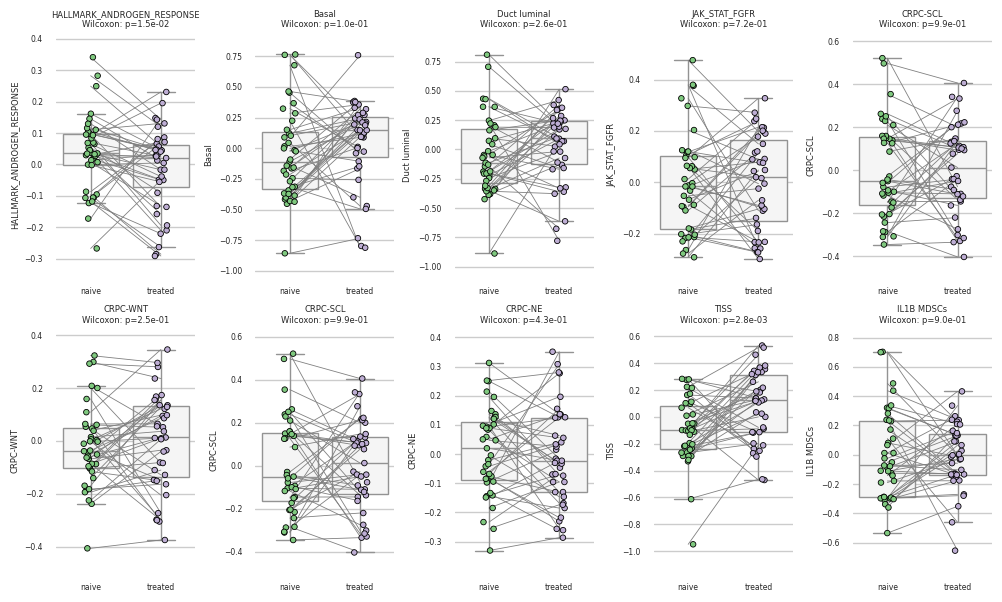

In [21]:
sns.set_theme(style='whitegrid', font_scale=0.5, palette='Accent')

# Only keep those with paired samples
plot_df = dat[dat['patient'].isin(meta['patient'].value_counts()[(meta['patient'].value_counts() == 2)].index)]

modules = [
    'HALLMARK_ANDROGEN_RESPONSE', 'Basal', 'Duct luminal', 'JAK_STAT_FGFR',#'HALLMARK_ANDROGEN_RESPONSE',#'CRPC-AR',
    'CRPC-SCL', 'CRPC-WNT','CRPC-SCL','CRPC-NE','TISS','IL1B MDSCs'
]

# Calculate the number of columns needed
num_modules = len(modules)
num_cols = 5
num_rows = int(np.ceil(num_modules / num_cols))  # 5 columns

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*2,num_rows * 3))

for idx, signature in enumerate(modules):
    row = idx // num_cols
    col = idx % num_cols

    ax = axs[row, col]

    sns.boxplot(data=plot_df, x='treatment_status', y=signature, color='whitesmoke', fliersize=0, ax=ax)
    sns.stripplot(data=plot_df, x='treatment_status', y=signature, hue='treatment_status', s=4, edgecolor='black', linewidth=0.6, legend=False, ax=ax)

    for patient in plot_df['patient'].unique():
        patient_data = plot_df[plot_df['patient'] == patient]
        ax.plot(patient_data['treatment_status'], patient_data[signature], color='gray', linestyle='-', linewidth=0.6)

    g1 = plot_df[plot_df['treatment_status'] == 'treated'].sort_values('patient')
    g2 = plot_df[plot_df['treatment_status'] == 'naive'].sort_values('patient')

    if (pd.Index(g2['patient']) == pd.Index(g2['patient'])).all():
        stat, pval = wilcoxon(g1[signature], g2[signature])
    else:
        stat = np.nan
        pval = np.nan

    ax.set_xlabel('')
    ax.set_ylim(plot_df[signature].min() * 1.2, plot_df[signature].max() * 1.2)
    ax.set_title(f'{signature}\nWilcoxon: p={pval:.1e}')
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout()

plt.savefig(f'./plots/tmp/boxplot.pdf')
#plt.savefig(f'./plots/DARANA_RNA_seq_treatment_paired_{signature}_score_AR_regressed_out.png',dpi=120)
#plt.savefig(f'./plots/DARANA_RNA_seq_treatment_paired_{signature}_score_AR_regressed_out.pdf')

### Individual gene

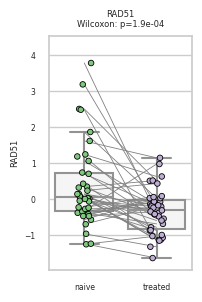

In [5]:

# Only keep those with paired samples
plot_df = dat[dat['patient'].isin(meta['patient'].value_counts()[(meta['patient'].value_counts() == 2)].index)]

gene_name = 'RAD51'

fig, ax = plt.subplots(figsize=(2,3))
sns.boxplot(data=plot_df, x='treatment_status', y=gene_name, color='whitesmoke', fliersize=0, ax=ax)
sns.stripplot(data=plot_df, x='treatment_status', y=gene_name, hue='treatment_status', s=4, edgecolor='black', linewidth=0.6, legend=False, ax=ax)

for patient in plot_df['patient'].unique():
    patient_data = plot_df[plot_df['patient'] == patient]
    ax.plot(patient_data['treatment_status'], patient_data[gene_name], color='gray', linestyle='-', linewidth=0.6)

g1 = plot_df[plot_df['treatment_status'] == 'treated'].sort_values('patient')
g2 = plot_df[plot_df['treatment_status'] == 'naive'].sort_values('patient')

if (pd.Index(g2['patient']) == pd.Index(g2['patient'])).all():
    stat, pval = wilcoxon(g1[gene_name], g2[gene_name])
else:
    stat = np.nan
    pval = np.nan

ax.set_xlabel('')
ax.set_ylim(plot_df[gene_name].min() * 1.2, plot_df[gene_name].max() * 1.2)
ax.set_title(f'{gene_name}\nWilcoxon: p={pval:.1e}')

plt.tight_layout()
plt.show()

### Signature score correlations

In [ ]:
x_var = 'scNMF Club'
x_var = 'BPECT Club Identity'

y_var = 'HALLMARK_PI3K_AKT_MTOR_SIGNALING'
#y_var = 'cGAS_STING_signaling_pathway'
#y_var = 'STING_non_canonical_DNA_DAMAGE'
#y_var = 'PMN-MDSC activity'
#y_var = 'CHD1_signaling_in_NF-κB_pathway'
#y_var = 'MDSC Calcinotto 2018'


sns.set_theme(style='white', palette='Accent',font_scale=0.5)

plot_dfs = [
    dat.copy(),
    dat[dat['treatment_status'] == 'naive'].copy(),
    dat[dat['treatment_status'] == 'treated'].copy(),

]

fig, axs = plt.subplots(1,3,figsize=(12,4.5),sharex=False,sharey=True)

for i,plot_df in enumerate(plot_dfs):
    ax = axs[i]
    xlims = [plot_df[x_var].min() + plot_df[x_var].min()*0.2, plot_df[x_var].max() + plot_df[x_var].max()*0.2]
    ylims = [plot_df[y_var].min() + plot_df[y_var].min()*0.2, plot_df[y_var].max() + plot_df[y_var].max()*0.2]

    # Calculate Spearman correlation
    corr, p_value = spearmanr(plot_df[x_var], plot_df[y_var])

    # Create the scatter plot with regression line

    sns.scatterplot(data=plot_df, x=x_var, y=y_var, hue="treatment_status",edgecolor='black',linewidth=0.5,legend=False,ax=ax)
    sns.regplot(data=plot_df, x=x_var, y=y_var, scatter=False, color='gray',ax=ax)

    # Add correlation and p-value text to the plot
    ax.set_title( f'Spearman Corr: {corr:.2f}\np-value: {p_value:.2e}')

x_var_save = x_var.replace(' ','_')
y_var_save = y_var.replace(' ','_')


plt.tight_layout()
# Show the plot

plt.savefig(plot_save_path + f'DARANA_{x_var_save}_{y_var_save}_correlation_plot_AR_regressed.png',dpi=120)
plt.savefig(plot_save_path + f'DARANA_{x_var_save}_{y_var_save}_correlation_plot_AR_regressed.pdf')
plt.show()


In [ ]:
# Gene signature scores post ANDROGEN RESPONSE FILTERING
modules = ['HALLMARK_ANDROGEN_RESPONSE',
           'BPECT Luminal Identity','BPECT Basal Identity','BPECT Club Identity','BPECT Hillock Identity',
           'CRPC-AR','CRPC-SCL','CRPC-WNT','CRPC-NE',
           'scNMF Club', 'MDSC Hirz 2023', 'MDSC Calcinotto 2018'
           ] 


corr_df_naive = dat.loc[(dat['treatment_status'] == 'naive'),modules].corr()

sns.clustermap(corr_df_naive,
               figsize=(4,4),
               cmap='bwr',
               vmax = 1,
               vmin = -1)

plt.title('ARNEO untreated GSVA score correlation')

plt.savefig('./plots/DARANA_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_naive.png',dpi=120)
plt.savefig('./plots/DARANA_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_naive.pdf')


plt.show()



In [ ]:

# Gene signature scores post ANDROGEN RESPONSE FILTERING
modules = ['Luminal Henry et al. 2018','Lung KACs Han et al. 2024','PDAC T1RS Caronni et al. 2023','scNMF Club','JAK_STAT_FGFR','Club Henry et al. 2018','Hillock Henry et al. 2018','CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE','PCCAT Scissor_CRPC_Enza_Epi UP','PCCAT Scissor_CRPC_Enza_Epi DOWN'] # gene_modules_dict.keys()

corr_df_treated = dat.loc[(dat['treatment_status'] == 'treated'),modules].corr()

sns.clustermap(corr_df_treated,
               figsize=(4,4),
               cmap='bwr',
               vmax = 1,
               vmin = -1)

plt.title('ARNEO treated GSVA score correlation')

plt.savefig('./plots/DARANA_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_treated.png',dpi=120)
plt.savefig('./plots/DARANA_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_treated.pdf')

plt.show()

## mCRPC SU2C Abida et al. 2019

In [9]:
dat = pd.read_csv('./data/prad_su2c_2019/data_mrna_seq_fpkm_polya.txt',sep='\t',index_col=0)
meta = pd.read_csv('./data/prad_su2c_2019/data_clinical_sample.txt',sep='\t',index_col=0,skiprows=[0,1,2,3])

dat = dat[~(dat.index.duplicated())]

valid_samples = meta.index.intersection(dat.columns)
dat = dat[valid_samples]
meta = meta.loc[valid_samples]

fpkm_abida = dat.copy()
#fpkm_abida_naive = fpkm_abida[fpkm_abida.columns.intersection(meta[meta['ABI_ENZA_EXPOSURE_STATUS'].isin(['Naive'])].index)]
#fpkm_abida_treated = fpkm_abida[fpkm_abida.columns.intersection(meta[meta['ABI_ENZA_EXPOSURE_STATUS'].isin(['On treatment','Exposed'])].index)]


### Install and run pySNAIL: https://github.com/kuijjerlab/PySNAIL

In [291]:
# Endpoint goal is to look at the correlation between the BPECT gene Identities --> Does treatment have an effect on their coexpression?
# Is there a mixing of the phenotypes? How does it work? Any implications?

#dat.to_csv('./data/prad_su2c_2019/su2c_pcf_for_pysnail_expression_data.tsv',sep='\t',index=True,header=True)
#meta[['ABI_ENZA_EXPOSURE_STATUS']].to_csv('./data/prad_su2c_2019/su2c_pcf_for_pysnail_groups.tsv',sep='\t',index=True,header=False)

# pysnail data/prad_su2c_2019/su2c_pcf_for_pysnail_expression_data.tsv --groups data/prad_su2c_2019/su2c_pcf_for_pysnail_groups.tsv --outdir pysnail_su2c_pcf_results

# ALTERNATIVELY: 
# No groups as they have been molecularly defined 
# pysnail data/prad_su2c_2019/su2c_pcf_for_pysnail_expression_data.tsv --outdir pysnail_su2c_pcf_results

# Load the corrected values

pysnail_corrected = pd.read_csv('./pysnail_su2c_pcf_results/xprs_norm.tsv',sep='\t',index_col=0).T

#valid_gene_modules = ['BPECT Luminal Identity', 'BPECT Basal Identity','BPECT Club Identity', 'BPECT Hillock Identity', ] #'scNMF senescent epithelium'
valid_gene_modules = ['CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE'] 

# Create the signature
df_signature = pd.DataFrame(columns=['gene','module'])
for k in valid_gene_modules:
    sig = gene_modules_dict[k].copy()
    df_signature = pd.concat([df_signature,pd.DataFrame({'gene':sig,'module':np.repeat(k,len(sig))})])
df_signature = df_signature[~(df_signature['gene'].duplicated())]

pysnail_corrected = pysnail_corrected[pysnail_corrected.columns.intersection(df_signature['gene'])]


/home/ak431480/.conda/envs/infercnvpy/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


CRPC-AR
CRPC-WNT
CRPC-SCL
CRPC-NE


[(0.4980392156862745, 0.788235294117647, 0.4980392156862745),
 (0.7450980392156863, 0.6823529411764706, 0.8313725490196079),
 (0.9921568627450981, 0.7529411764705882, 0.5254901960784314),
 (1.0, 1.0, 0.6)]

<Figure size 600x600 with 0 Axes>

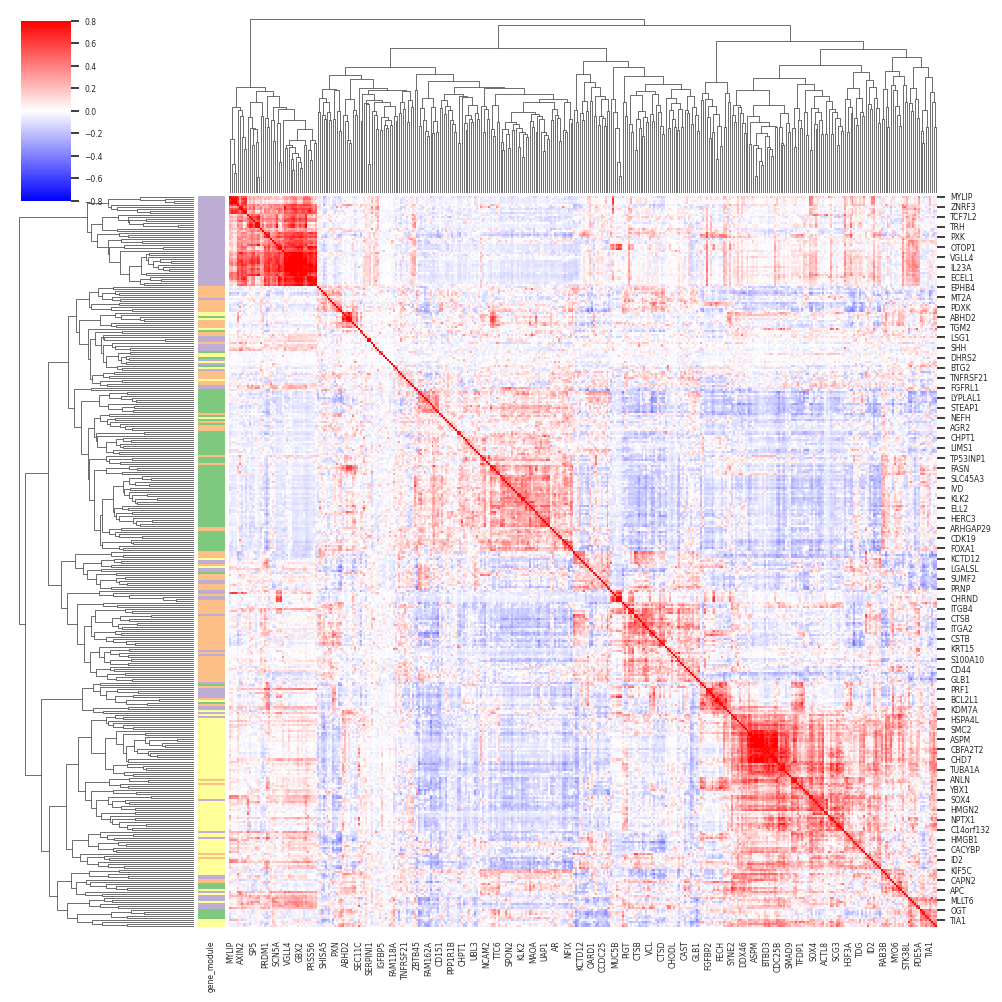

In [292]:
sns.set_theme(style='white',font_scale=0.5)

pysnail_corrected_corr = pysnail_corrected.corr()

# Add an annotation column
pysnail_corrected_corr['gene_module'] = pd.Categorical(df_signature.set_index('gene').loc[pysnail_corrected_corr.index]['module'],categories=valid_gene_modules)

# Annotate the gene modules with colors
pal = sns.color_palette('Accent')
lut = dict(zip(valid_gene_modules, [pal[0], pal[1],pal[2],pal[3]]))

plt.figure(figsize=(6,6))
p = sns.clustermap(pysnail_corrected_corr.drop('gene_module', axis=1), row_colors = pysnail_corrected_corr['gene_module'].astype('object').map(lut),cmap='bwr', center = 0, vmin = -0.8, vmax = 0.8)

[print(k) for k in lut.keys()]
sns.color_palette(lut.values())

#plt.savefig('./plots/tmp/heatmap.pdf')

### Based on the dendrogram above, determine whether any cluster is enriched in specific gene sets

In [293]:
df = p.data2d.copy()

# Get the linkage matrix
linkage_matrix = p.dendrogram_row.linkage

# Define the number of clusters
num_clusters = 4

# Get the cluster labels
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')


for cl in (np.arange(num_clusters) + 1):

    cluster_genes = set(df.loc[df.index.intersection(pysnail_corrected_corr.iloc[cluster_labels == cl].index)].index)
    for sig_name in valid_gene_modules:
    
        sig = set(gene_modules_dict[sig_name])

        a = len(sig.intersection(cluster_genes))
        b = len(sig.difference(cluster_genes))
        c = len(cluster_genes.difference(sig))
        d = len(df) - a - b - c
        arr = np.array([[a,b],[c,d]])
        stat, pval = fisher_exact(arr)
        if (stat > 1) & (pval < 0.05):
            print(f'Cluster {cl} - {sig_name}: stat = {stat:.1f}, p = {pval:.1e} !')
        else:
            print(f'Cluster {cl} - {sig_name}: stat = {stat:.1f}, p = {pval:.1e}')
    print('')

Cluster 1 - CRPC-AR: stat = 0.0, p = 7.6e-07
Cluster 1 - CRPC-WNT: stat = inf, p = 9.0e-32 !
Cluster 1 - CRPC-SCL: stat = 0.0, p = 7.6e-07
Cluster 1 - CRPC-NE: stat = 0.0, p = 7.6e-07

Cluster 2 - CRPC-AR: stat = 6.1, p = 6.0e-11 !
Cluster 2 - CRPC-WNT: stat = 0.2, p = 9.3e-10
Cluster 2 - CRPC-SCL: stat = 11.4, p = 1.5e-16 !
Cluster 2 - CRPC-NE: stat = 0.1, p = 1.9e-21

Cluster 3 - CRPC-AR: stat = 0.4, p = 3.8e-01
Cluster 3 - CRPC-WNT: stat = 4.0, p = 7.4e-03 !
Cluster 3 - CRPC-SCL: stat = 0.7, p = 7.7e-01
Cluster 3 - CRPC-NE: stat = 0.4, p = 3.8e-01

Cluster 4 - CRPC-AR: stat = 0.2, p = 7.8e-08
Cluster 4 - CRPC-WNT: stat = 0.3, p = 1.2e-04
Cluster 4 - CRPC-SCL: stat = 0.1, p = 2.2e-09
Cluster 4 - CRPC-NE: stat = 51.0, p = 1.7e-41 !



## Labrecque et al. mCRPC bulk data

In [2]:
# Download data and format metadata
dat = pd.read_csv('./data/labrecque_2019/GSE126078_norm_counts_TPM_GRCh38.p13_NCBI.tsv',sep='\t',index_col=0) # NCBI-generated TPM matrix from https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE126078

# Replace Entrez IDs with gene symbols
gene_annot = pd.read_csv('./data/labrecque_2019/Human.GRCh38.p13.annot.tsv',sep='\t')
gene_mapping_dict = gene_annot.set_index('GeneID')['Symbol'].to_dict()
dat.index = dat.index.map(gene_mapping_dict)

meta = pd.read_csv('./data/labrecque_2019/GSE126078_series_matrix.txt',sep='\t',skiprows=51,index_col=0)
# Extract relevant columns
meta = meta.T[['!Sample_geo_accession','!Sample_characteristics_ch1','!Sample_source_name_ch1']]

# Drop unused columns
meta = pd.DataFrame(meta.iloc[:,[0,4,5,7]])
column_names = ['GEO_ID','patient','molecular_phenotype','metastatic_site']
meta.columns = column_names

# Map the sample names onto columns
geo_to_sample_dict = meta.reset_index().set_index('GEO_ID')['index'].to_dict()
dat.columns = dat.columns.map(geo_to_sample_dict)

CRPC_only = True #### Adjust accordingly
if CRPC_only:
    meta = meta[meta.index.str.contains('CRPC')]
    dat = dat[meta.index.tolist()]
    meta['molecular_phenotype'] = pd.Categorical([s.split(': ')[1] for s in meta['molecular_phenotype']],categories=['ARpos_NEneg','ARpos_NEpos','ARneg_NEpos','ARlow_NEneg','ARneg_NEneg'])



## TPM normalization
gtf_file = '/lustre/scratch/kiviaho/refdata-gex-GRCh38-2020-A/genes/genes.gtf'


# Extract gene lengths from the GTF file
gene_lengths_mapping_dict = extract_gene_lengths_from_gtf(gtf_file)

# Subset the pseudobulk data to only contain those genes that have annotation
#dat = dat[dat.index.isin(gene_lengths_mapping_dict.keys())]

# Map the gene lengts to pseudobulk genes 
gene_length_mapping = dat.index.map(gene_lengths_mapping_dict).tolist()

# Transform gene lenghts to kilobase
gene_length_mapping = np.array(gene_length_mapping,dtype=float)/1e3


# Perform TPM normalization
tpm = calculate_tpm(dat,gene_length_mapping)
tpm = tpm[~(tpm.isna().all(axis=1))]

print((meta.index == dat.columns).all())

# Need to run new scoring after getting rid of the overlap between two genes
gsva_res = gp.gsva(data=tpm,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')


/tmp/ipykernel_5980/455201028.py:5: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_annot = pd.read_csv('./data/labrecque_2019/Human.GRCh38.p13.annot.tsv',sep='\t')


True


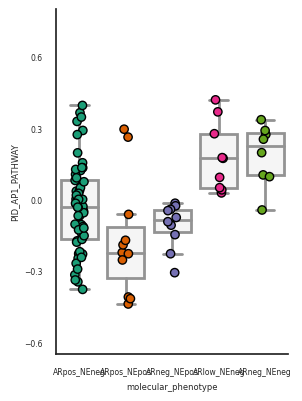

ARpos_NEneg vs ARpos_NEpos: 2.4e-02 *
ARpos_NEneg vs ARneg_NEpos: 0.18
ARpos_NEneg vs ARlow_NEneg: 1.3e-03 **
ARpos_NEneg vs ARneg_NEneg: 2.8e-03 **
ARpos_NEpos vs ARneg_NEpos: 0.16
ARpos_NEpos vs ARlow_NEneg: 5.6e-03 **
ARpos_NEpos vs ARneg_NEneg: 8.2e-03 **
ARneg_NEpos vs ARlow_NEneg: 2.4e-04 ***
ARneg_NEpos vs ARneg_NEneg: 1.0e-03 **
ARlow_NEneg vs ARneg_NEneg: 0.70


In [7]:
gsva_res_meta = pd.merge(meta,gsva_res_df, right_on='Sample Identifier',left_index=True)

# Drop the molecule 
#gsva_res_meta['molecular_phenotype_simple'] = gsva_res_meta['molecular_phenotype'].map({'ARpos_NEneg':'AR+','ARpos_NE_pos':'AR+','ARneg_NEpos':np.nan,'ARlow_NEneg':'AR-','ARneg_NEneg':'AR-'}).astype('category')
#gsva_res_meta = gsva_res_meta.dropna()

sns.set_theme(style=('white'),palette='Dark2',font_scale=0.5)

#sig = 'BPECT Club Identity'
sig = 'PID_AP1_PATHWAY'
var = 'molecular_phenotype'
#var = 'molecular_phenotype_simple'

stat, p_val = kruskal(*gsva_res_meta[[var,sig]].groupby(var)[sig].apply(list))

fig, ax = plt.subplots(figsize=(3,4))

sns.stripplot(gsva_res_meta,
              x = var,
              y = sig,
              hue = var,
              edgecolor='black',
              linewidth = 1.0,
              s = 6,
              legend = False,
              ax = ax
              )


sns.boxplot(data=gsva_res_meta,
            x=var,
            y=sig,
            color='whitesmoke',
            showfliers=False,
            linewidth=2,
            ax=ax)

ax.set_ylim(-0.65,0.8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([-0.6,-0.3,0,0.3,0.6])

plt.tight_layout()
plt.savefig('./plots/tmp/boxplot.pdf')
#plt.savefig(f'./plots/Labracque_et_al_{sig}_GSVA_score_by_{var}.pdf')
plt.show()

for grp1, grp2 in list(combinations(gsva_res_meta[var].cat.categories,2)):
    stat, pval = ranksums(gsva_res_meta[gsva_res_meta[var] == grp1][sig],
                            gsva_res_meta[gsva_res_meta[var] == grp2][sig])

    if pval < 0.001:
        print(f'{grp1} vs {grp2}: {pval:.1e} ***')
    
    elif pval < 0.01:
        print(f'{grp1} vs {grp2}: {pval:.1e} **')
    
    elif pval < 0.05:
        print(f'{grp1} vs {grp2}: {pval:.1e} *')
    
    elif pval >= 0.05:
        print(f'{grp1} vs {grp2}: {pval:.2f}')


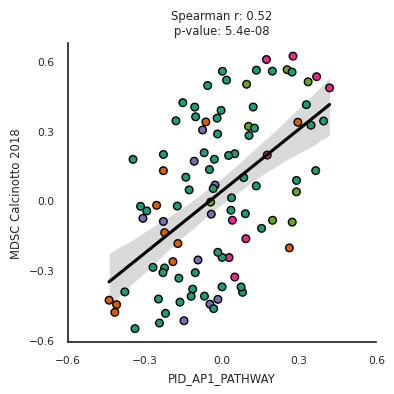

In [14]:
sns.set_theme(style='white',palette='Dark2',font_scale=0.7)

sig = 'MDSC Calcinotto 2018'
#sig = 'HALLMARK_ANDROGEN_RESPONSE'
correlation_var = 'PID_AP1_PATHWAY'

df = pd.merge(meta,gsva_res_df, right_on='Sample Identifier',left_index=True)

df[sig] = df[sig].astype('float64')
df[correlation_var] = df[correlation_var].astype('float64')

fig, ax = plt.subplots(figsize=(4,4))

stat, pval = spearmanr(df[sig],df[correlation_var])

sns.regplot(df,
                x = correlation_var,
                y= sig,
                scatter=False,
                color='black',
                ax=ax
                )

sns.scatterplot(df,
                x = correlation_var,
                y= sig,
                edgecolor='black',
                hue = 'molecular_phenotype',
                linewidth=1,
                s = 30,
                legend=None,
                ax=ax
                )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([-0.6,-0.3,0,0.3,0.6])
ax.set_yticks([-0.6,-0.3,0,0.3,0.6])

ax.set_title(f'Spearman r: {stat:.2f}\np-value: {pval:.1e}')

plt.tight_layout()
plt.savefig('./plots/tmp/regplot.pdf')

plt.show()

### Install and run pySNAIL: https://github.com/kuijjerlab/PySNAIL

In [294]:
# Endpoint goal is to look at the correlation between the BPECT gene Identities --> Does treatment have an effect on their coexpression?
# Is there a mixing of the phenotypes? How does it work? Any implications?

#dat.to_csv('./data/labrecque_2019/labrecque_for_pysnail_expression_data.tsv',sep='\t',index=True,header=True)

# No groups as they have been molecularly defined 
# pysnail data/labrecque_2019/labrecque_for_pysnail_expression_data.tsv --groups ./data/labrecque_2019/labrecque_for_pysnail_groups.tsv --outdir pysnail_labrecque_results

# Load the corrected values

pysnail_corrected = pd.read_csv('./pysnail_labrecque_results/xprs_norm.tsv',sep='\t',index_col=0).T

#valid_gene_modules = ['CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE'] 
valid_gene_modules = ['BPECT Luminal Identity', 'BPECT Basal Identity','BPECT Club Identity', 'BPECT Hillock Identity',] #'BPECT Neuroendocrine Identity'] #'scNMF senescent epithelium'

# Create the signature
df_signature = pd.DataFrame(columns=['gene','module'])
for k in valid_gene_modules:
    sig = gene_modules_dict[k].copy()
    df_signature = pd.concat([df_signature,pd.DataFrame({'gene':sig,'module':np.repeat(k,len(sig))})])
df_signature = df_signature[~(df_signature['gene'].duplicated())]

pysnail_corrected = pysnail_corrected[pysnail_corrected.columns.intersection(df_signature['gene'])]


/home/ak431480/.conda/envs/infercnvpy/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


BPECT Luminal Identity
BPECT Basal Identity
BPECT Club Identity
BPECT Hillock Identity


[(0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.4, 0.7607843137254902, 0.6470588235294118),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

<Figure size 600x600 with 0 Axes>

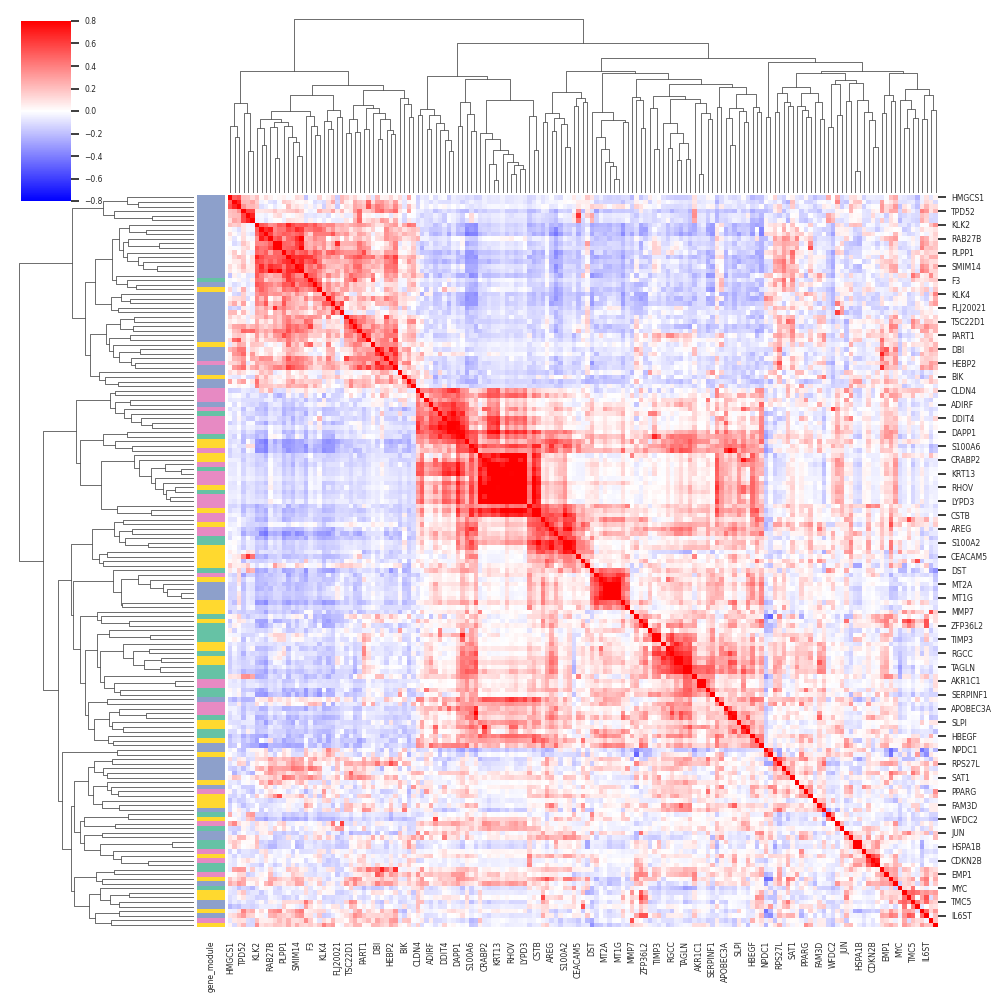

In [297]:
sns.set_theme(style='white',font_scale=0.5)

pysnail_corrected_corr = pysnail_corrected.corr()

# Add an annotation column
pysnail_corrected_corr['gene_module'] = pd.Categorical(df_signature.set_index('gene').loc[pysnail_corrected_corr.index]['module'],categories=valid_gene_modules)

# Annotate the gene modules with colors
#pal = sns.color_palette('Accent')
#lut = dict(zip(valid_gene_modules, [pal[0], pal[1],pal[2],pal[3]]))

pal = sns.color_palette('Set2')
lut = dict(zip(valid_gene_modules, [pal[2], pal[0],pal[5],pal[3]]))


plt.figure(figsize=(6,6))
p = sns.clustermap(pysnail_corrected_corr.drop('gene_module', axis=1), row_colors = pysnail_corrected_corr['gene_module'].astype('object').map(lut),cmap='bwr', center = 0, vmin = -0.8, vmax = 0.8)

[print(k) for k in lut.keys()]
sns.color_palette(lut.values())

#plt.savefig('./plots/tmp/heatmap.pdf')

### Based on the dendrogram above, determine whether any cluster is enriched in specific gene sets

In [296]:
# Get the linkage matrix
linkage_matrix = p.dendrogram_row.linkage

# Define the number of clusters
num_clusters = 4

# Get the cluster labels
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

df = p.data2d.copy()

for cl in (np.arange(num_clusters) + 1):

    cluster_genes = set(df.loc[df.index.intersection(pysnail_corrected_corr.iloc[cluster_labels == cl].index)].index)
    for sig_name in valid_gene_modules:
    
        sig = set(gene_modules_dict[sig_name])

        a = len(sig.intersection(cluster_genes))
        b = len(sig.difference(cluster_genes))
        c = len(cluster_genes.difference(sig))
        d = len(df) - a - b - c
        arr = np.array([[a,b],[c,d]])
        stat, pval = fisher_exact(arr)
        if (stat > 1) & (pval < 0.05):
            print(f'Cluster {cl} - {sig_name}: stat = {stat:.1f}, p = {pval:.1e} !')
        else:
            print(f'Cluster {cl} - {sig_name}: stat = {stat:.1f}, p = {pval:.1e}')
    print('')

Cluster 1 - BPECT Luminal Identity: stat = 32.0, p = 1.3e-15 !
Cluster 1 - BPECT Basal Identity: stat = 0.1, p = 9.1e-04
Cluster 1 - BPECT Club Identity: stat = 0.2, p = 1.5e-03
Cluster 1 - BPECT Hillock Identity: stat = 0.1, p = 1.5e-04

Cluster 2 - BPECT Luminal Identity: stat = 0.0, p = 1.9e-05
Cluster 2 - BPECT Basal Identity: stat = 0.7, p = 6.0e-01
Cluster 2 - BPECT Club Identity: stat = 0.8, p = 8.1e-01
Cluster 2 - BPECT Hillock Identity: stat = 10.4, p = 4.2e-07 !

Cluster 3 - BPECT Luminal Identity: stat = 0.1, p = 6.5e-06
Cluster 3 - BPECT Basal Identity: stat = 3.8, p = 1.8e-03 !
Cluster 3 - BPECT Club Identity: stat = 2.2, p = 4.8e-02 !
Cluster 3 - BPECT Hillock Identity: stat = 0.7, p = 5.4e-01

Cluster 4 - BPECT Luminal Identity: stat = 0.9, p = 1.0e+00
Cluster 4 - BPECT Basal Identity: stat = 0.9, p = 1.0e+00
Cluster 4 - BPECT Club Identity: stat = 1.5, p = 4.0e-01
Cluster 4 - BPECT Hillock Identity: stat = 0.6, p = 3.7e-01



### PELICAN cohort

In [ ]:

# Extract the gene_id to gene_name mapping table from the GTF file
gtf_file = '/lustre/scratch/kiviaho/refdata-gex-GRCh38-2020-A/genes/genes.gtf'


# Create a gene id-gene symbol table
gene_mapping_df = extract_gene_mapping(gtf_file)
gene_mapping_dict = gene_mapping_df.set_index('gene_id').to_dict()['gene_name']
print(gene_mapping_df.head())

# Data downloads

dat = pd.read_csv('../hillock_club_senescence/data/pelican/PELICAN45_rna_featureCounts.txt',sep = '\t',index_col=0,skiprows=1)
dat = dat.drop(columns=['Chr','Start','End','Strand','Length']) # Drop unused
dat.columns = [s.replace('Aligned.sortedByCoord.out.bam','') for s in dat.columns] # Shorten sample names

dat.index = [r.split('.')[0] for r in dat.index] # strip gene version from index

# Replace the index with gene symbols
dat.index = dat.index.map(gene_mapping_dict)
dat = dat[~(dat.index.isna())]
dat = dat[~(dat.sum(axis=1) == 0)]
#dat = dat[~(dat.sum(axis=1) <= dat.shape[1])]
#dat = dat[(dat != 0).sum(axis=1) >= dat.shape[1]/2] # Non-zero counts in 10% of the samples

dat = dat.reset_index().groupby('index').sum() # Summarize duplicated genes


## TPM normalization

# Extract gene lengths from the GTF file
gene_lengths_mapping_dict = extract_gene_lengths_from_gtf(gtf_file)

# Subset the pseudobulk data to only contain those genes that have annotation
#dat = dat[dat.index.isin(gene_lengths_mapping_dict.keys())]

# Map the gene lengts to pseudobulk genes 
gene_length_mapping = dat.index.map(gene_lengths_mapping_dict).tolist()

# Transform gene lenghts to kilobase
gene_length_mapping = np.array(gene_length_mapping,dtype=float)/1e3


# Perform TPM normalization
tpm = calculate_tpm(dat,gene_length_mapping)
tpm = tpm[~(tpm.isna().all(axis=1))]


In [ ]:
# Need to run new scoring after getting rid of the overlap between two genes
gsva_res = gp.gsva(data=tpm,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

modules = ['HALLMARK_ANDROGEN_RESPONSE','Luminal Henry et al. 2018','Lung KACs Han et al. 2024','AR signaling','PDAC T1RS Caronni et al. 2023','scNMF Club','JAK_STAT_FGFR','Club Henry et al. 2018','Hillock Henry et al. 2018','CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE','PCCAT Scissor_CRPC_Enza_Epi UP','PCCAT Scissor_CRPC_Enza_Epi DOWN'] # gene_modules_dict.keys()

#'MDSC Hirz 2023','MDSC Calcinotto 2018','PMN-MDSC activity','STING_non_canonical_DNA_DAMAGE','CHD1_signaling_in_NF-κB_pathway',

corr_df = gsva_res_df[modules].astype('float').corr()

sns.clustermap(corr_df,
               figsize=(4,4),
               cmap='bwr')

plt.title('PELICAN cohort GSVA score correlation')
#plt.tight_layout()
plt.show()

## ARNEO longer

In [1]:

# Using the real set of RNA-seq data

rnaseq_data = pd.read_csv('/lustre/scratch/kiviaho/hillock_club_senescence/data/arneo-rnaseq/TR169-arneo-tpm-star-rsem.csv',index_col=0)
metadata = pd.read_csv('/lustre/scratch/kiviaho/hillock_club_senescence/data/arneo-rnaseq/case-metadata.txt',index_col=0,sep='\t')

rnaseq_data = rnaseq_data.drop(columns=['ensembl_gene_id','entrezgene_id']).set_index('hgnc_symbol')

missing_meta = pd.DataFrame({
    'TRT_GROUP':np.repeat('treatment-naive',len(rnaseq_data.columns.difference(metadata.index))),
    'tc': np.nan,
    'tc_method': np.nan,
    }, index = rnaseq_data.columns.difference(metadata.index)
    )

metadata = pd.concat([metadata,missing_meta])

# Create a treatment-naive vs neoadjuvant-treated divide
metadata['TRT_GROUP_SIMPLE'] = pd.Categorical(metadata['TRT_GROUP'].map({'treatment-naive':'treatment-naive','adt':'neoadjuvant-treated','adt_apa':'neoadjuvant-treated'}),categories=['treatment-naive','neoadjuvant-treated'])
metadata['tc'] = metadata['tc'].astype('float')

# Subset to treatment-naive
#metadata = metadata[metadata['TRT_GROUP'] == 'treatment-naive']

# Match the ordering
rnaseq_data = rnaseq_data[metadata.index.intersection(rnaseq_data.columns)]
metadata = metadata.loc[rnaseq_data.columns.intersection(metadata.index)]

""" 
# Calculate GSVA enrichment
gsva_res_df = gsva_res_df.loc[metadata.index.intersection(gsva_res_df.index)]
gsva_res = gp.gsva(data=rnaseq_data,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')
gsva_res_df = gsva_res_df.set_index('Sample Identifier').astype('float')

if (gsva_res_df.index == metadata.index).all():
    dat = pd.concat([gsva_res_df,metadata], axis=1)

# Regressing out androgen response
gsva_res_df = regress_out_signature(gsva_res_df, 'HALLMARK_ANDROGEN_RESPONSE') # HALLMARK_ANDROGEN_RESPONSE, AR signaling general
gsva_res_df = regress_out_signatures(gsva_res_df, ['HALLMARK_ANDROGEN_RESPONSE','Fibroblast region','Muscle region']) # HALLMARK_ANDROGEN_RESPONSE, AR signaling
    
 """

rnaseq_data_zscore = zscore(rnaseq_data,axis=1)

# Calculate median Z-score of the set of genes
median_zscore = pd.DataFrame(columns = gene_modules_dict.keys(),index = rnaseq_data_zscore.columns)
for k in gene_modules_dict:
    sig = rnaseq_data_zscore.index.intersection(gene_modules_dict[k])
    median_zscore[k] = rnaseq_data_zscore.loc[sig].median()

# Regress out the effect of andorgen signaling
#median_zscore = regress_out_signatures(median_zscore, ['HALLMARK_ANDROGEN_RESPONSE','BPECT Luminal Identity'])

if (median_zscore.index == metadata.index).all():
    dat = pd.concat([median_zscore,metadata], axis=1)

dat = pd.concat([dat,rnaseq_data_zscore.T],axis=1)

dat['TRT_GROUP'] = pd.Categorical(dat['TRT_GROUP'],categories=['treatment-naive','adt','adt_apa']).remove_unused_categories()
dat['TRT_GROUP_SIMPLE'] = pd.Categorical(dat['TRT_GROUP'].map({'treatment-naive':'treatment-naive','adt':'neoadjuvant-treated','adt_apa':'neoadjuvant-treated'}),categories=['treatment-naive','neoadjuvant-treated'])


NameError: name 'pd' is not defined

### Install and run pySNAIL: https://github.com/kuijjerlab/PySNAIL

In [348]:
# Endpoint goal is to look at the correlation between the BPECT gene Identities --> Does treatment have an effect on their coexpression?
# Is there a mixing of the phenotypes? How does it work? Any implications?

#rnaseq_data.to_csv('./data/arneo-rnaseq/arneo_for_pysnail_expression_data.tsv',sep='\t',index=True,header=True)
#metadata[['TRT_GROUP']].to_csv('./data/arneo-rnaseq/arneo_for_pysnail_groups.tsv',sep='\t',index=True,header=False)

# pysnail data/arneo-rnaseq/arneo_for_pysnail_expression_data.tsv --groups data/arneo-rnaseq/arneo_for_pysnail_groups.tsv --outdir pysnail_arneo

# Load the corrected values

pysnail_corrected = pd.read_csv('./pysnail_arneo_results/xprs_norm.tsv',sep='\t',index_col=0).T


valid_gene_modules = ['BPECT Luminal Identity', 'BPECT Basal Identity','BPECT Club Identity', 'BPECT Hillock Identity',] #'BPECT Neuroendocrine Identity'] #'scNMF senescent epithelium'
poor_prognosis_genes = ['AREG','DDIT4','OAS1','PPARG','CLDN4','DHRS9','EMP1','IL1RN','KRT13','OAF','S100A9','SDC1','SERPINB1','TMPRSS4','CCL20','LYPD3','PLAUR','SDCBP2']
                       # 'PI3','SLPI','CXCL6','BIK','CEACAM6','REEP3','RHOV','CAV2','DEFB1','DKK1','CAV1','KRT17','MYC','PHLDA1','FHL2','HSPA1A','KRT14']

# Create the signature
df_signature = pd.DataFrame(columns=['gene','module'])
for k in valid_gene_modules:
    sig = gene_modules_dict[k].copy()
    df_signature = pd.concat([df_signature,pd.DataFrame({'gene':sig,'module':np.repeat(k,len(sig))})])
df_signature = df_signature[~(df_signature['gene'].duplicated())]

pysnail_corrected = pysnail_corrected[pysnail_corrected.columns.intersection(df_signature['gene'])]


/home/ak431480/.conda/envs/infercnvpy/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 600x600 with 0 Axes>

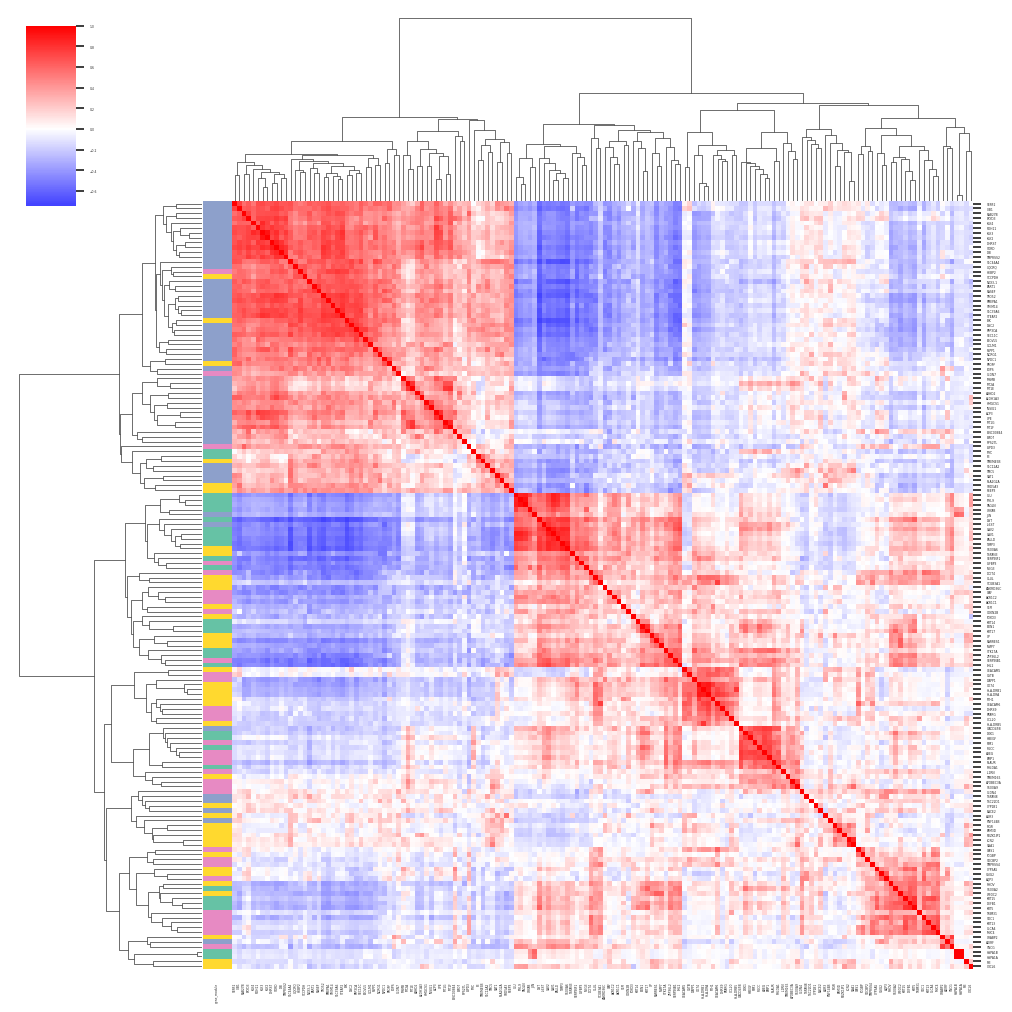

In [341]:
sns.set_theme(style='white',font_scale=0.2)

categories = ['treatment-naive','adt','adt_apa']
samples_to_include = metadata[metadata['TRT_GROUP'].isin(categories)].index.tolist()
pysnail_corrected_corr = pysnail_corrected.loc[samples_to_include].corr()

# Add an annotation column
pysnail_corrected_corr['gene_module'] = pd.Categorical(df_signature.set_index('gene').loc[pysnail_corrected_corr.index]['module'],categories=valid_gene_modules)

# Annotate the gene modules with colors
pal = sns.color_palette('Set2')
lut = dict(zip(valid_gene_modules, [pal[2], pal[0],pal[5],pal[3]]))

plt.figure(figsize=(6,6))
p = sns.clustermap(pysnail_corrected_corr.drop('gene_module', axis=1), row_colors = pysnail_corrected_corr['gene_module'].astype('object').map(lut),cmap='bwr', center = 0)

#plt.savefig('./plots/tmp/heatmap.pdf')

### Poor prognosis-associated genes

/home/ak431480/.conda/envs/infercnvpy/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 600x600 with 0 Axes>

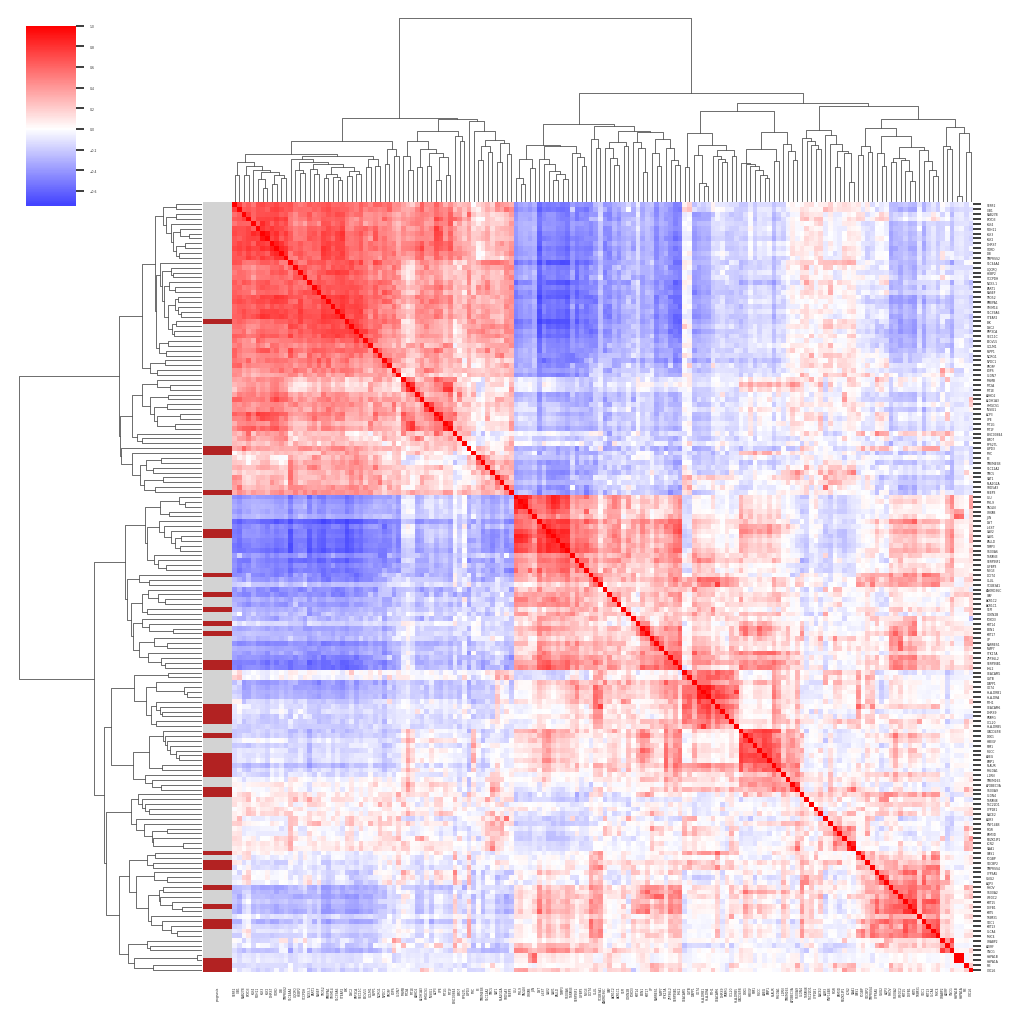

In [342]:
sns.set_theme(style='white',font_scale=0.2)

categories = ['treatment-naive','adt','adt_apa']
samples_to_include = metadata[metadata['TRT_GROUP'].isin(categories)].index.tolist()
pysnail_corrected_corr = pysnail_corrected.loc[samples_to_include].corr()

pysnail_corrected_corr['prognosis'] = 'NA'
pysnail_corrected_corr.loc[poor_prognosis_genes,'prognosis'] = 'Poor'

# Annotate the gene modules with colors
pal = sns.color_palette(['lightgray','firebrick'])
lut = dict(zip(['NA','Poor'], [pal[0], pal[1]]))


plt.figure(figsize=(6,6))
p = sns.clustermap(pysnail_corrected_corr.drop('prognosis', axis=1), row_colors = pysnail_corrected_corr['prognosis'].astype('object').map(lut),cmap='bwr', center = 0)

plt.savefig('./plots/tmp/heatmap.pdf')

### Based on the dendrogram above, determine whether any cluster is enriched in specific gene sets

In [346]:
# Get the linkage matrix
linkage_matrix = p.dendrogram_row.linkage

# Define the number of clusters
num_clusters = len(valid_gene_modules)

# Get the cluster labels
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

df = p.data2d.copy()

for cl in (np.arange(num_clusters) + 1):

    cluster_genes = set(df.loc[df.index.intersection(pysnail_corrected_corr.iloc[cluster_labels == cl].index)].index)
    for sig_name in valid_gene_modules:
    
        sig = set(gene_modules_dict[sig_name])

        a = len(sig.intersection(cluster_genes))
        b = len(sig.difference(cluster_genes))
        c = len(cluster_genes.difference(sig))
        d = len(df) - a - b - c
        arr = np.array([[a,b],[c,d]])
        stat, pval = fisher_exact(arr)
        if (stat > 1) & (pval < 0.05):
            print(f'Cluster {cl} - {sig_name}: stat = {stat:.1f}, p = {pval:.1e} !')
        else:
            print(f'Cluster {cl} - {sig_name}: stat = {stat:.1f}, p = {pval:.1e}')
    print('')

Cluster 1 - BPECT Luminal Identity: stat = 39.2, p = 3.4e-20 !
Cluster 1 - BPECT Basal Identity: stat = 0.1, p = 4.2e-05
Cluster 1 - BPECT Club Identity: stat = 0.2, p = 5.8e-04
Cluster 1 - BPECT Hillock Identity: stat = 0.1, p = 4.3e-05

Cluster 2 - BPECT Luminal Identity: stat = 0.1, p = 2.8e-06
Cluster 2 - BPECT Basal Identity: stat = 7.5, p = 5.9e-06 !
Cluster 2 - BPECT Club Identity: stat = 1.2, p = 6.7e-01
Cluster 2 - BPECT Hillock Identity: stat = 0.8, p = 8.2e-01

Cluster 3 - BPECT Luminal Identity: stat = 0.1, p = 6.9e-05
Cluster 3 - BPECT Basal Identity: stat = 0.8, p = 7.9e-01
Cluster 3 - BPECT Club Identity: stat = 1.5, p = 4.5e-01
Cluster 3 - BPECT Hillock Identity: stat = 4.7, p = 1.2e-03 !

Cluster 4 - BPECT Luminal Identity: stat = 0.2, p = 4.6e-04
Cluster 4 - BPECT Basal Identity: stat = 0.8, p = 8.1e-01
Cluster 4 - BPECT Club Identity: stat = 2.6, p = 1.9e-02 !
Cluster 4 - BPECT Hillock Identity: stat = 1.8, p = 1.8e-01



In [349]:

for cl in (np.arange(num_clusters) + 1):

    cluster_genes = set(df.loc[df.index.intersection(pysnail_corrected_corr.iloc[cluster_labels == cl].index)].index)
    sig = set(poor_prognosis_genes)

    a = len(sig.intersection(cluster_genes))
    b = len(sig.difference(cluster_genes))
    c = len(cluster_genes.difference(sig))
    d = len(df) - a - b - c
    arr = np.array([[a,b],[c,d]])
    stat, pval = fisher_exact(arr)
    if (stat > 1) & (pval < 0.05):
        print(f'Cluster {cl} - poor prognosis genes: stat = {stat:.1f}, p = {pval:.4f} !')
    else:
        print(f'Cluster {cl} - poor prognosis genes: stat = {stat:.1f}, p = {pval:.4f}')
    print(arr)
    print('')

Cluster 1 - poor prognosis genes: stat = 0.1, p = 0.0017
[[ 1 17]
 [59 81]]

Cluster 2 - poor prognosis genes: stat = 0.6, p = 0.7657
[[  3  15]
 [ 33 107]]

Cluster 3 - poor prognosis genes: stat = 5.8, p = 0.0020 !
[[  8  10]
 [ 17 123]]

Cluster 4 - poor prognosis genes: stat = 1.8, p = 0.3734
[[  6  12]
 [ 31 109]]



In [185]:
cl = 3
df.loc[df.index.intersection(pysnail_corrected_corr.iloc[cluster_labels == cl].index),df.index.intersection(pysnail_corrected_corr.iloc[cluster_labels == cl].index)]

,CEACAM5,CSTB,DAPP1,CD74,HLA-DRB1,HLA-DRA,FTH1,CEACAM6,DHRS9,PPARG,...,PIM1,RGCC,AREG,EMP1,PLAUR,PHLDA1,IL1RN,TMEM165,APOBEC3A,S100A9
CEACAM5,1.000000,0.572427,0.325016,0.538786,0.556291,0.592894,0.465910,0.655197,0.567558,0.504060,...,0.000725,0.003354,-0.013545,-0.048787,0.342932,0.225590,0.058302,0.172093,0.017011,0.290497
CSTB,0.572427,1.000000,0.397298,0.561755,0.548532,0.651589,0.625139,0.629733,0.509723,0.558799,...,0.017109,0.079029,0.020378,-0.036479,0.378016,0.268795,0.234475,0.169146,0.033595,0.297940
DAPP1,0.325016,0.397298,1.000000,0.549065,0.549601,0.549748,0.384850,0.361355,0.307432,0.260184,...,0.292735,0.345579,0.358519,0.208165,0.405719,0.324413,0.029589,0.172623,0.065395,0.219107
CD74,0.538786,0.561755,0.549065,1.000000,0.876151,0.911135,0.778130,0.628404,0.634869,0.542077,...,0.100035,0.120774,0.101727,0.055391,0.470848,0.277918,0.085492,0.106255,0.071736,0.236411
HLA-DRB1,0.556291,0.548532,0.549601,0.876151,1.000000,0.886764,0.629372,0.731629,0.641032,0.532664,...,0.145606,0.153426,0.100900,0.062861,0.521895,0.334599,0.095811,0.121434,0.080745,0.320944
HLA-DRA,0.592894,0.651589,0.549748,0.911135,0.886764,1.000000,0.661490,0.770806,0.738414,0.666166,...,0.135793,0.135079,0.100518,0.087200,0.543740,0.358331,0.132338,0.112526,0.085072,0.288436
FTH1,0.465910,0.625139,0.384850,0.778130,0.629372,0.661490,1.000000,0.518628,0.508353,0.440914,...,-0.028034,0.097322,0.001157,-0.026224,0.350457,0.191697,0.109881,0.196625,0.094134,0.184483
CEACAM6,0.655197,0.629733,0.361355,0.628404,0.731629,0.770806,0.518628,1.000000,0.675706,0.604481,...,0.022024,0.118883,0.024557,-0.001409,0.416039,0.267047,0.121548,0.100546,0.025404,0.321498
DHRS9,0.567558,0.509723,0.307432,0.634869,0.641032,0.738414,0.508353,0.675706,1.000000,0.566329,...,0.085575,0.082103,0.060853,0.093977,0.439420,0.388931,0.073785,-0.007798,0.050422,0.201215
PPARG,0.504060,0.558799,0.260184,0.542077,0.532664,0.666166,0.440914,0.604481,0.566329,1.000000,...,0.014741,0.014988,-0.016606,0.020283,0.377191,0.295062,0.218697,0.072963,-0.021402,0.135390


### Score correlations with regards to treatment

/home/ak431480/.conda/envs/infercnvpy/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/home/ak431480/.conda/envs/infercnvpy/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/home/ak431480/.conda/envs/infercnvpy/lib/python3.8/site-packages/seaborn/re

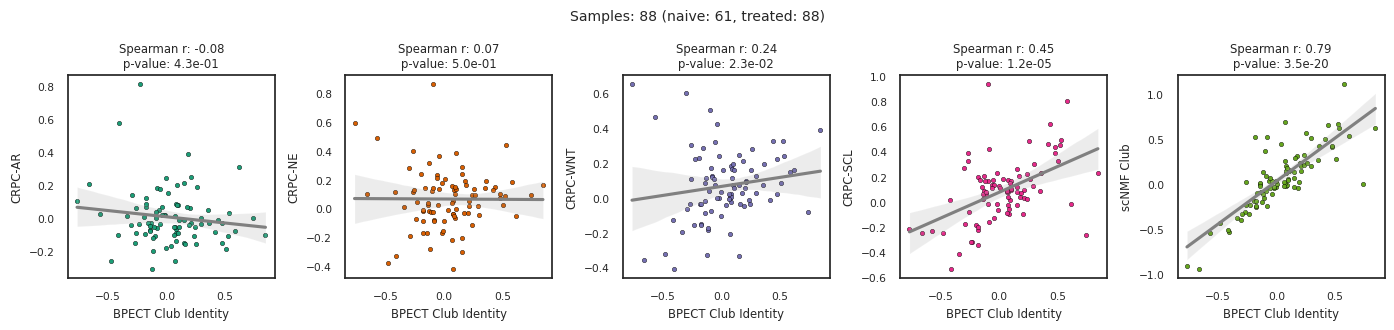

In [4]:
sns.set_theme(style='white',font_scale=0.7)

pal = sns.color_palette('Dark2')
correlation_var = 'BPECT Club Identity'

df = dat.copy()
#df = df[df['TRT_GROUP_SIMPLE'] == 'treatment-naive'] # Just the treated samples
df = df[df['TRT_GROUP_SIMPLE'] == 'neoadjuvant-treated'] # Just the treated samples
df = df[~df[correlation_var].isna()]
signatures = ['CRPC-AR','CRPC-NE','CRPC-WNT','CRPC-SCL','scNMF Club']
fig, axs = plt.subplots(1,5,figsize=(14,3.3))
for i,sig in enumerate(signatures):
    
    ax = axs[i]
    stat, pval = spearmanr(df[sig],df[correlation_var])
    sns.scatterplot(df,
                    x = correlation_var,
                    y= sig,
                    edgecolor='black',
                    linewidth=0.3,
                    c=pal[i],
                    s = 10,
                    ax=ax
                    )
    sns.regplot(df,
                    x = correlation_var,
                    y= sig,
                    scatter=False,
                    color='gray',
                    ax=ax
                    )
    

    ax.set_title(f'Spearman r: {stat:.2f}\np-value: {pval:.1e}')

n_naive = len(dat[dat['TRT_GROUP_SIMPLE'] == 'treatment-naive'])
n_treated = len(dat[dat['TRT_GROUP_SIMPLE'] == 'neoadjuvant-treated'])

plt.suptitle(f'Samples: {len(df)} (naive: {n_naive}, treated: {n_treated})')
plt.tight_layout()


#plt.savefig('plots/ARNEO_rnaseq_CRPC_subtype_gsva_score_vs_pcf_select_tc.png',dpi=120)
#plt.savefig(f'plots/ARNEO_rnaseq_CRPC_subtype_gsva_score_vs_{correlation_var}_treated.png',dpi=120)
#plt.savefig(f'plots/ARNEO_rnaseq_CRPC_subtype_gsva_score_vs_{correlation_var}_naive.png',dpi=120)

plt.show()

### Plot the treatment-induced score change

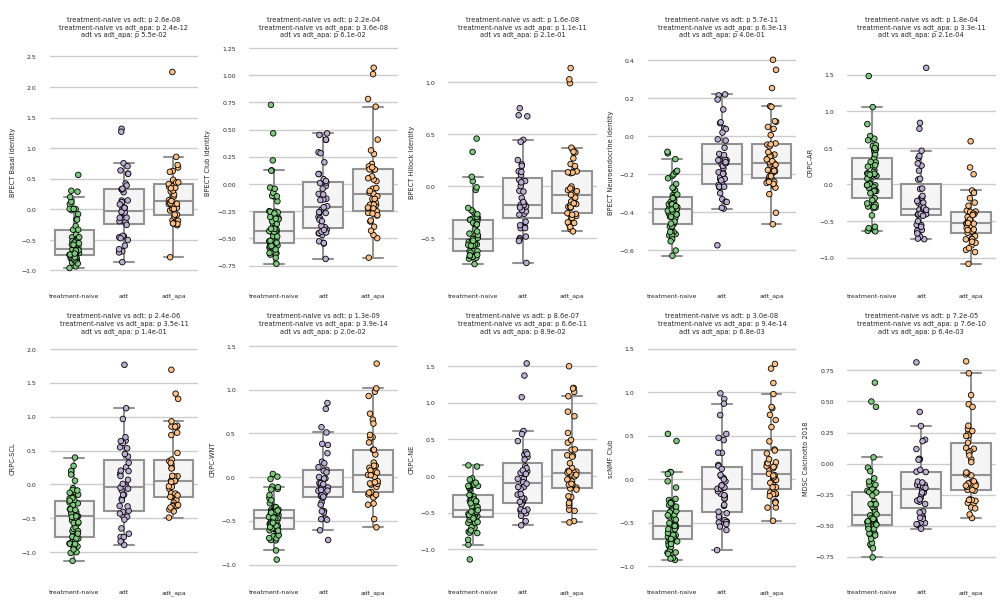

In [5]:
# USE MEDIAN ZSCORE REGRESSED FOR HALLMARK_ANDROGEN_RESPONSE & BPECT LUMINAL IDENTITY

# Simple
sns.set_theme(style='whitegrid',font_scale=0.4,palette='Accent')

modules = [#'BPECT Luminal Identity',
    'BPECT Basal Identity', 'BPECT Club Identity', 'BPECT Hillock Identity', 'BPECT Neuroendocrine Identity',
    'CRPC-AR', 'CRPC-SCL', 'CRPC-WNT', 'CRPC-NE', 'scNMF Club', 'MDSC Calcinotto 2018'#'JAK_STAT_FGFR'
]

cat = 'TRT_GROUP'#'TRT_GROUP_SIMPLE'

# Calculate the number of columns needed
num_modules = len(modules)
num_cols = 5
num_rows = int(np.ceil(num_modules / num_cols))  # 5 columns

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*2,num_rows * 3))

for idx, signature in enumerate(modules):
    row = idx // num_cols
    col = idx % num_cols

    ax = axs[row, col]

    sns.boxplot(data=dat, x=cat, y=signature,color='whitesmoke',fliersize=0, ax = ax)

    sns.stripplot(dat,
                x = cat,
                y = signature,
                hue = cat,
                #color='gray',
                s = 4,
                edgecolor='black',
                linewidth = 0.6,
                legend=False,
                ax = ax
                )

    g1 = dat[dat[cat] == 'treatment-naive']
    g2 = dat[dat[cat] == 'neoadjuvant-treated']

    # Add p-value to the title
    title = ''

    for g1, g2 in list(combinations(dat[cat].cat.categories,2)):
        stat, pval = ranksums(dat[dat[cat] == g1][signature],
                dat[dat[cat] == g2][signature])
        title = title + '\n' + f'{g1} vs {g2}: p {pval:.1e}'

    ax.set_xlabel('')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_ylim(dat[signature].min() * 1.2, dat[signature].max() * 1.2)
    ax.set_title(f'{title}')

plt.tight_layout()

#plt.savefig('./plots/tmp/boxplot.pdf')
plt.show()


### Single gene

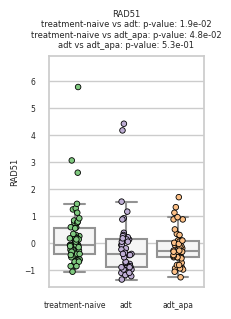

In [8]:
# USE MEDIAN ZSCORE REGRESSED FOR HALLMARK_ANDROGEN_RESPONSE & BPECT LUMINAL IDENTITY

# Simple
sns.set_theme(style='whitegrid',font_scale=0.5,palette='Accent')

gene_name = 'RAD51'
cat = 'TRT_GROUP'

plt.figure(figsize=(2,3))

sns.boxplot(data=dat, x=cat, y=gene_name,color='whitesmoke',fliersize=0)

sns.stripplot(dat,
            x = cat,
            y = gene_name,
            hue = cat,
            #color='gray',
            s = 4,
            edgecolor='black',
            linewidth = 0.6,
            legend=False
            )

g1 = dat[dat[cat] == 'treatment-naive']
g2 = dat[dat[cat] == 'neoadjuvant-treated']

# Add p-value to the title
title = gene_name

for g1, g2 in list(combinations(dat[cat].cat.categories,2)):
    stat, pval = ranksums(dat[dat[cat] == g1][gene_name],
            dat[dat[cat] == g2][gene_name])
    title = title + '\n' + f'{g1} vs {g2}: p-value: {pval:.1e}'

plt.xlabel('')

plt.ylim(dat[gene_name].min()*1.2,dat[gene_name].max()*1.2)
plt.title(title)

plt.show()


### Gene score correlation plot

/home/ak431480/.conda/envs/infercnvpy/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/home/ak431480/.conda/envs/infercnvpy/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/home/ak431480/.conda/envs/infercnvpy/lib/python3.8/site-packages/seaborn/re

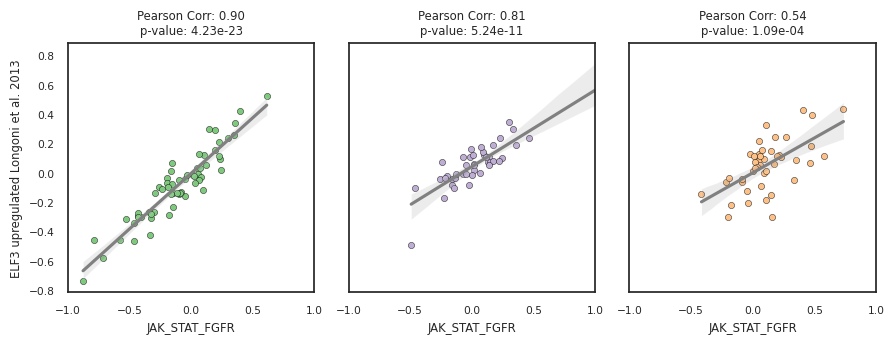

In [62]:
sns.set_theme(style='white', palette='Accent',font_scale=0.7)
x_var = 'JAK_STAT_FGFR'#'scNMF Club','HALLMARK_PI3K_AKT_MTOR_SIGNALING' 
y_var = 'ELF3 upregulated Longoni et al. 2013'#'BPECT Club Identity'
pal = sns.color_palette('Accent')

plot_dfs = [
    #dat.copy(),
    dat[dat['TRT_GROUP'] == 'treatment-naive'].copy(),
    dat[dat['TRT_GROUP'] == 'adt'].copy(),
    dat[dat['TRT_GROUP'] == 'adt_apa'].copy()

]

fig, axs = plt.subplots(1,len(plot_dfs),figsize=(3* len(plot_dfs),3.5),sharex=False,sharey=True)

xlims = [dat[x_var].min()*1.2, dat[x_var].max() *1.2]
xlims = [-1,1]

for i,plot_df in enumerate(plot_dfs):
    ax = axs[i]

    # Calculate Spearman correlation
    corr, p_value = spearmanr(plot_df[x_var], plot_df[y_var])

    # Create the scatter plot with regression line

    sns.scatterplot(plot_df,
                x = x_var,
                y= y_var,
                edgecolor='black',
                linewidth=0.3,
                c=pal[i],
                s = 20,
                ax=ax
                )
    sns.regplot(plot_df,
                x = x_var,
                y= y_var,
                scatter=False,
                color='gray',
                ax=ax
                )
    
    ax.set_xlim(xlims)
    # Add correlation and p-value text to the plot
    ax.set_title( f'Pearson Corr: {corr:.2f}\np-value: {p_value:.2e}')

x_var_save = x_var.replace(' ','_')
y_var_save = y_var.replace(' ','_')


plt.tight_layout()
# Show the plot

#plt.savefig(plot_save_path + f'ARNEO_{x_var_save}_{y_var_save}_correlation_plot.png',dpi=120)
#plt.savefig(plot_save_path + f'ARNEO_{x_var_save}_{y_var_save}_correlation_plot.pdf')
plt.show()


In [50]:
var1 = 'JAK_STAT_FGFR'
grp = 'adt_apa'

corr_df = dat.loc[(dat['TRT_GROUP'] == grp),dat.columns.intersection(gene_modules_dict.keys())].corr()
corr_series = corr_df[var].sort_values(ascending=False)
top10 = corr_series[:10].index
corr_series[:10]

JAK_STAT_FGFR                             1.000000
CRPC-WNT                                  0.733085
CRPC-NE                                   0.732161
HALLMARK_PI3K_AKT_MTOR_SIGNALING          0.725934
ELF3 upregulated Longoni et al. 2013      0.611380
TNF_NFKB_signaling_pathway                0.608920
Canonical_STING_innate_immune_response    0.536476
Prostate IL1A_B+ MDSCs (aggr.)            0.491753
PCCAT Scissor_Synergistic_BCROS_Epi UP    0.472418
Regulators_extracellular_cGAMP            0.467101
Name: JAK_STAT_FGFR, dtype: float64

In [56]:
from scipy.stats import fisher_exact
for var2 in top10:
    series1 = gene_modules[var1].dropna()
    series2 = gene_modules[var2].dropna()
    # Calculate the overlap between the two series
    overlap = len(set(series1) & set(series2))

    # Total space
    total_space = len(rnaseq_data_zscore)

    # Create the contingency table
    contingency_table = [[overlap, len(series1) - overlap], [len(series2) - overlap, total_space - len(series1) - len(series2) + overlap]]

    # Perform Fisher's exact test
    odds_ratio, p_value = fisher_exact(contingency_table)

    #print(set(series1).intersection(set(series2)))
    print(var2)
    print(f'Overlap: {overlap}')
    print(f"Odds Ratio: {odds_ratio:.1f}")
    if p_value < 0.05:
        print(f"P-value: {p_value:.2e} !!")
    else:
        print(f"P-value: {p_value:.2e}")
    print('')

JAK_STAT_FGFR
Overlap: 63
Odds Ratio: inf
P-value: 2.70e-200 !!

CRPC-WNT
Overlap: 3
Odds Ratio: 19.8
P-value: 6.02e-04 !!

CRPC-NE
Overlap: 0
Odds Ratio: 0.0
P-value: 1.00e+00

HALLMARK_PI3K_AKT_MTOR_SIGNALING
Overlap: 6
Odds Ratio: 37.9
P-value: 3.27e-08 !!

ELF3 upregulated Longoni et al. 2013
Overlap: 1
Odds Ratio: 5.8
P-value: 1.62e-01

TNF_NFKB_signaling_pathway
Overlap: 1
Odds Ratio: 38.4
P-value: 2.78e-02 !!

Canonical_STING_innate_immune_response
Overlap: 2
Odds Ratio: 106.5
P-value: 2.35e-04 !!

Prostate IL1A_B+ MDSCs (aggr.)
Overlap: 4
Odds Ratio: 8.3
P-value: 1.77e-03 !!

PCCAT Scissor_Synergistic_BCROS_Epi UP
Overlap: 0
Odds Ratio: 0.0
P-value: 1.00e+00

Regulators_extracellular_cGAMP
Overlap: 0
Odds Ratio: 0.0
P-value: 1.00e+00



In [ ]:
# Gene signature scores post ANDROGEN RESPONSE FILTERING
modules = ['Luminal Henry et al. 2018','Lung KACs Han et al. 2024','PDAC T1RS Caronni et al. 2023','scNMF Club','JAK_STAT_FGFR','Club Henry et al. 2018','Hillock Henry et al. 2018','CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE','PCCAT Scissor_CRPC_Enza_Epi UP','PCCAT Scissor_CRPC_Enza_Epi DOWN'] # gene_modules_dict.keys()

corr_df_naive = dat.loc[(dat['TRT_GROUP_SIMPLE'] == 'treatment-naive'),modules].corr()

sns.clustermap(corr_df_naive,
               figsize=(4,4),
               cmap='bwr',
               vmax = 1,
               vmin = -1)

plt.title('ARNEO untreated GSVA score correlation')

plt.savefig('./plots/ARNEO_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_naive.png',dpi=120)
plt.savefig('./plots/ARNEO_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_naive.pdf')


plt.show()

In [ ]:
# Gene signature scores post ANDROGEN RESPONSE FILTERING
modules = ['Luminal Henry et al. 2018','Lung KACs Han et al. 2024','PDAC T1RS Caronni et al. 2023','scNMF Club','JAK_STAT_FGFR','Club Henry et al. 2018','Hillock Henry et al. 2018','CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE','PCCAT Scissor_CRPC_Enza_Epi UP','PCCAT Scissor_CRPC_Enza_Epi DOWN'] # gene_modules_dict.keys()

corr_df_treated = dat.loc[(dat['TRT_GROUP_SIMPLE'] == 'neoadjuvant-treated'),modules].corr()

sns.clustermap(corr_df_treated,
               figsize=(4,4),
               cmap='bwr',
               vmax = 1,
               vmin = -1)

plt.title('ARNEO treated GSVA score correlation')

plt.savefig('./plots/ARNEO_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_treated.png',dpi=120)
plt.savefig('./plots/ARNEO_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_treated.pdf')

plt.show()

### Check which samples has ATAC-seq data

In [ ]:
arneo_atac = pd.read_csv('./ARNEO_ATAC_seq_deviation_scores.txt',sep='\t')
gsva_res_atac = gsva_res_df.loc[gsva_res_df['Sample Identifier'].isin(arneo_atac.columns),['Sample Identifier','scNMF Club','CRPC-SCL','TRT_GROUP']]

gsva_res_atac = gsva_res_atac.sort_values('CRPC-SCL',ascending=False).reset_index(drop=True)
gsva_res_atac['CRPC-SCL score rank'] = np.arange(len(gsva_res_atac)) + 1 

gsva_res_atac = gsva_res_atac.sort_values('scNMF Club',ascending=False).reset_index(drop=True)
gsva_res_atac['scNMF Club score rank'] = np.arange(len(gsva_res_atac)) + 1 


gsva_res_atac

In [ ]:
gsva_res_atac.to_excel('./ARNEO_RNA_seq_scores_for_ATAC_seq_samples.xlsx',index=False)

In [ ]:
plot_df = df.copy()
plot_df = plot_df[plot_df['Sample Identifier'].isin(gsva_res_atac['Sample Identifier'].tolist())]


sns.set_theme(style='white',palette='Accent')

# Define the params for drawing significance bars
textprops = [
    {'ymaxm':1.15, 'xmin':0.2,'xmax':0.45,'textx':0.5,'textym':1.17},
    {'ymaxm':1.45, 'xmin':0.2,'xmax':0.8,'textx':1,'textym':1.47},
    {'ymaxm':1.25, 'xmin':0.55,'xmax':0.8,'textx':1.5,'textym':1.27},
]

score_name = 'CRPC-SCL'

min_value = plot_df[score_name].min()
max_value = plot_df[score_name].max()

# Create the axes
fig, axs = plt.subplots(1,2,figsize=(6,4),sharey=False,gridspec_kw={'width_ratios':[3,2]})

ax = axs[0]

# Plot the box + swarplot on the first axis
sns.boxplot(data=plot_df, x='TRT_GROUP', y=score_name,color='whitesmoke',ax=ax,fliersize=0)
sns.swarmplot(data=plot_df, x='TRT_GROUP', y=score_name,hue='TRT_GROUP',ax=ax,legend=None)

# Get the unique categories in 'TRT_GROUP'
categories = plot_df['TRT_GROUP'].cat.categories

# Perform pairwise Wilcoxon rank-sum tests
it=0
for i in range(len(categories)):
    for j in range(i+1, len(categories)):
        cat1 = categories[i]
        cat2 = categories[j]
        
        # Get the data for each category
        data1 = plot_df[plot_df['TRT_GROUP'] == cat1][score_name]
        data2 = plot_df[plot_df['TRT_GROUP'] == cat2][score_name]
        
        # Perform Wilcoxon rank-sum test
        statistic, p_value = ranksums(data1, data2)
        asterisks = ''
        if p_value < 0.001:
            asterisks = '***'
        elif p_value < 0.01:
            asterisks = '**'
        elif p_value < 0.05:
            asterisks = '*'

        if p_value < 0.05:
            props_dict = textprops[it]
            ax.axhline(y = max_value*props_dict['ymaxm'], xmin=props_dict['xmin'],xmax=props_dict['xmax'],c='black')
            ax.text(s=asterisks,x=props_dict['textx'],y=max_value*props_dict['textym'],ha='center',fontdict={'fontsize':12})
        it += 1
        
ax.set_ylim(min_value*1.2,max_value*1.7)

# Create a kernel density plot on the second ax object
ax = axs[1]
sns.kdeplot(
data=plot_df, y=score_name, hue='TRT_GROUP',
fill=True, common_norm=False,
alpha=.5, linewidth=0, legend=None,
ax=ax
)
ax.set_ylim(min_value*1.2,max_value*1.7)

# Strip all but the plot from this axis
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.suptitle(score_name + ' GSVA score split by treatment')
plt.tight_layout()

s = score_name.replace(' ','_').replace('/','_')
plt.savefig(plot_save_path + f'{s}_gsva_score_split_by_treatment_atac_samples.pdf')
plt.savefig(plot_save_path + f'{s}_gsva_score_split_by_treatment_atac_samples.png',dpi=120) 
plt.show()

In [ ]:
treated_gsva_res = gsva_res_atac[gsva_res_atac['TRT_GROUP'].isin(['adt','adt_apa'])]
qntiles = treated_gsva_res['scNMF Club'].describe()

treated_gsva_res[treated_gsva_res['scNMF Club'] <= qntiles['25%']]

In [ ]:
treated_gsva_res[treated_gsva_res['scNMF Club'] >= qntiles['75%']]

### Examine gene modules overlap and DEGs of single genes

In [ ]:
signatures = ['JAK_STAT_FGFR','scNMF Club'] # JAK_STAT_FGFR, JAK_STAT_ACTIVATORS, scNMF senescent epithelium, 'Club Henry et al. 2018','scNMF club_interferon', PMN-MDSC activity, PMN_MDSC_signature

# Ensure all genes are present in the index
fishers_df = pd.DataFrame(index = pd.Index(set(rnaseq_data.index.tolist()  + all_genes )))
for sig_name in signatures:

    sig = gene_modules_dict[sig_name]
    sig = [g for g in sig if g in fishers_df.index.tolist()]

    #preface
    fishers_df[sig_name] = 'no'
    fishers_df.loc[sig,sig_name] = 'yes'

    fishers_df[sig_name] = pd.Categorical(fishers_df[sig_name],categories=['yes','no'])

fishers_df = pd.crosstab(fishers_df[signatures[0]],fishers_df[signatures[1]])
overlap = set(gene_modules_dict[signatures[0]]).intersection(set(gene_modules_dict[signatures[1]]))

#fishers_df.iloc[0,0] +=1
print(overlap)
oddsratio, pval = fisher_exact(fishers_df)

print(fishers_df)
print(f'OR: {oddsratio:.2f}, p-value: {pval:.2e}')

### Plot a 3-way venn diagram with club region markers & Henry et al. signatures

## Differential gene expression analysis

In [ ]:
from statsmodels.stats.multitest import multipletests

def run_differential_expression_test(df1,df2):

    # Create a results_df
    result = pd.DataFrame(index=df1.index, columns=['avg_lfc','stat','p_value'],dtype=np.float64)
    result['avg_lfc'] = df1.mean(axis=1) - df2.mean(axis=1)

    for g in tqdm(df1.index,unit='gene'):
        stat,pval = ranksums(df1.loc[g],df2.loc[g])
        result.loc[g,'stat'] = stat
        result.loc[g,'p_value'] = pval

    # Perform BH correction
    result['adj_pval'] = multipletests(result['p_value'], method='fdr_bh')[1]

    return(result)

In [ ]:
# Load the data

# Define sample categories
trt_naive = rnaseq_data[metadata[metadata['TRT_GROUP'] == 'treatment-naive'].index]
adt_treated = rnaseq_data[metadata[metadata['TRT_GROUP'] == 'adt'].index]
adt_apa_treated = rnaseq_data[metadata[metadata['TRT_GROUP'] == 'adt_apa'].index]
neadt_treated_all = rnaseq_data[metadata[metadata['TRT_GROUP_SIMPLE'] == 'neoadjuvant-treated'].index]

# Run differential expression testing between the sample categories
deg_adt_res = run_differential_expression_test(adt_treated,trt_naive)
deg_adt_apa_res = run_differential_expression_test(adt_apa_treated,trt_naive)
deg_treated_untreated = run_differential_expression_test(neadt_treated_all,trt_naive)

In [ ]:
save_excel = False

# Get the upregulated genes
adt_upreg = deg_adt_res[(deg_adt_res['avg_lfc']>= 1) & (deg_adt_res['adj_pval'] < 0.05)].index.tolist()
adt_apa_upreg = deg_adt_apa_res[(deg_adt_apa_res['avg_lfc']>= 1) & (deg_adt_apa_res['adj_pval'] < 0.05)].index.tolist()

arneo_degs_df = pd.DataFrame.from_dict({'adt':adt_upreg,'adt_apa':adt_apa_upreg},orient='index').T

if save_excel:
    # Create a Pandas Excel writer using XlsxWriter as the engine
    with pd.ExcelWriter('arneo_deg_results.xlsx', engine='xlsxwriter') as writer:
        # Write each dataframe to a different worksheet
        deg_adt_res.to_excel(writer, sheet_name='degarelix', index=True)
        deg_adt_apa_res.to_excel(writer, sheet_name='degarelix+apalutamide', index=True)
    writer.save()

# Format the data for easy access
deg_adt_res['treatment_grp'] = 'adt'
deg_adt_apa_res['treatment_grp'] = 'adt_apa'

deg_res = pd.concat([deg_adt_res[['avg_lfc','adj_pval','treatment_grp']],
           deg_adt_apa_res[['avg_lfc','adj_pval','treatment_grp']]
])

### Volcano plot treatment-naïve vs neoadjuvant-treated

In [ ]:
sns.set_theme(style='white', palette=sns.color_palette(['lightgray','firebrick']),font_scale=0.5)

col_name = 'scNMF Club'
plot_df = deg_treated_untreated
lfc_thr = 0.5

#plot_df = deg_res.loc[set(gene_modules_dict[col_name]).intersection(deg_res.index)]

plot_df['annotation'] = 'anone'
plot_df.loc[set(gene_modules_dict[col_name]).intersection(set(plot_df.index)),'annotation'] = 'gene_set'

plot_df['-log10_adj_pval'] = -np.log10(plot_df['adj_pval'])
plot_df = plot_df.sort_values('annotation')

fig, ax = plt.subplots(figsize=(4,3))

sns.scatterplot(data=plot_df,
                x='avg_lfc',
                y='-log10_adj_pval',
                linewidth=0.1,
                edgecolor='black',
                s=10,
                hue='annotation',
                legend=False,
                ax=ax)

ax.set_xlim(-4, 4)
ax.set_ylim(-0.5, plot_df['-log10_adj_pval'].max() + 1)
ax.axhline(y=-np.log10(0.05), color='black', linestyle='--')
ax.axvline(x=-lfc_thr, color='black', linestyle='--')
ax.axvline(x=lfc_thr, color='black', linestyle='--')

ax.set_title(f'DE results for genes in {col_name}')

annot_genes = ['ELF3','KLF5','SOX9','PIGR','LTF','MMP7']
# Adding gene name labels
for i in range(len(plot_df)):
    if (np.abs(plot_df['avg_lfc'].iloc[i]) >= lfc_thr and plot_df['adj_pval'].iloc[i] < 0.05) & (plot_df.index[i] in gene_modules_dict[col_name]):
        if plot_df.index[i] in annot_genes:
            ax.text(plot_df['avg_lfc'].iloc[i], 
                    plot_df['-log10_adj_pval'].iloc[i], 
                    plot_df.index[i], 
                    fontsize=6, 
                    ha='left')

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

gene_set = col_name.replace(' ','_')
plt.savefig(plot_save_path + f'{gene_set}_degs_volcano_plot_treat_naive_vs_neoadjuvant_treated.pdf')

plt.show()


In [ ]:
plot_df[plot_df['annotation'] == 'gene_set'].sort_values('avg_lfc',ascending=False)[:30]

In [ ]:
gene_modules_dict['Upregulated'] = plot_df[(plot_df['adj_pval'] < 0.05) & (plot_df['avg_lfc'] >= 0.5)].index.tolist()
gene_modules_dict['Downregulated'] = plot_df[(plot_df['adj_pval'] < 0.05) & (plot_df['avg_lfc'] <= -0.5)].index.tolist()

In [ ]:
signatures = ['Downregulated','scNMF Club'] # JAK_STAT_FGFR, JAK_STAT_ACTIVATORS, scNMF senescent epithelium, 'Club Henry et al. 2018','scNMF club_interferon', PMN-MDSC activity, PMN_MDSC_signature

# Ensure all genes are present in the index
fishers_df = pd.DataFrame(index = pd.Index(set(rnaseq_data.index.tolist()  + all_genes )))
for sig_name in signatures:
    if sig_name in gene_modules_dict:
        sig  = gene_modules_dict[sig_name]
    else:
        print('Signature name not found')
    sig = [g for g in sig if g in fishers_df.index.tolist()]

    #preface
    fishers_df[sig_name] = 'no'
    fishers_df.loc[sig,sig_name] = 'yes'

    fishers_df[sig_name] = pd.Categorical(fishers_df[sig_name],categories=['yes','no'])

fishers_df = pd.crosstab(fishers_df[signatures[0]],fishers_df[signatures[1]])
overlap = set(gene_modules_dict[signatures[0]]).intersection(set(gene_modules_dict[signatures[1]]))

#fishers_df.iloc[0,0] +=1
print(overlap)
oddsratio, pval = fisher_exact(fishers_df)

print(fishers_df)
print(f'OR: {oddsratio:.2f}, p-value: {pval:.2e}')

### Volcano plots ADT / ADT-APA specified

In [ ]:
sns.set_theme(style='white', palette='Accent',font_scale=0.5)

col_name = 'scNMF Club'
plot_df = deg_res.loc[set(gene_modules_dict[col_name]).intersection(deg_res.index)]
lfc_thr = 0.5

plot_df['-log10_adj_pval'] = -np.log10(plot_df['adj_pval'])
plot_df['treatment_grp'] = pd.Categorical(plot_df['treatment_grp'], categories=['treatment-naive', 'adt', 'adt_apa'])

fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(data=plot_df,
                x='avg_lfc',
                y='-log10_adj_pval',
                #s=10,
                linewidth=0.5,
                edgecolor='black',
                hue='treatment_grp',
                legend=False,
                ax=ax)

ax.set_xlim(-1.5, 2.5)
ax.set_ylim(-0.5, plot_df['-log10_adj_pval'].max() + 1)
ax.axhline(y=-np.log10(0.05), color='black', linestyle='--')
ax.axvline(x=-lfc_thr, color='black', linestyle='--')
ax.axvline(x=lfc_thr, color='black', linestyle='--')

ax.set_title(f'DE results for genes in {col_name}')


annot_genes = ['ELF3','KLF5','SOX9','KRT13','IGFBP3','CRABP2','TACSTD2','PSCA']
if len(gene_modules_dict[col_name]) < 140:
    # Adding gene name labels
    for i in range(len(plot_df)):
        #if np.abs(plot_df['avg_lfc'].iloc[i]) >= lfc_thr and plot_df['adj_pval'].iloc[i] < 0.05:
        if plot_df.index[i] in annot_genes:
            ax.text(plot_df['avg_lfc'].iloc[i], 
                    plot_df['-log10_adj_pval'].iloc[i], 
                    plot_df.index[i], 
                    fontsize=6, 
                    ha='left')

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

gene_set = col_name.replace(' ','_')
plt.savefig(plot_save_path + f'{gene_set}_degs_volcano_plot.pdf')

plt.show()


In [ ]:
plot_df.sort_values('avg_lfc',ascending=False)[:30]

In [ ]:
gene_modules_dict['Upregulated'] = deg_res[(deg_res['adj_pval'] < 0.05) & (deg_res['avg_lfc'] >= 0.5)].index.unique().tolist()
gene_modules_dict['Downregulated'] = deg_res[(deg_res['adj_pval'] < 0.05) & (deg_res['avg_lfc'] <= -0.5)].index.unique().tolist()

In [ ]:
signatures = ['Upregulated','scNMF Club'] # JAK_STAT_FGFR, JAK_STAT_ACTIVATORS, scNMF senescent epithelium, 'Club Henry et al. 2018','scNMF club_interferon', PMN-MDSC activity, PMN_MDSC_signature

# Ensure all genes are present in the index
fishers_df = pd.DataFrame(index = pd.Index(set(rnaseq_data.index.tolist()  + all_genes )))
for sig_name in signatures:
    if sig_name in gene_modules_dict:
        sig  = gene_modules_dict[sig_name]
    else:
        print('Signature name not found')
    sig = [g for g in sig if g in fishers_df.index.tolist()]

    #preface
    fishers_df[sig_name] = 'no'
    fishers_df.loc[sig,sig_name] = 'yes'

    fishers_df[sig_name] = pd.Categorical(fishers_df[sig_name],categories=['yes','no'])

fishers_df = pd.crosstab(fishers_df[signatures[0]],fishers_df[signatures[1]])
overlap = set(gene_modules_dict[signatures[0]]).intersection(set(gene_modules_dict[signatures[1]]))

#fishers_df.iloc[0,0] +=1
print(overlap)
oddsratio, pval = fisher_exact(fishers_df)

print(fishers_df)
print(f'OR: {oddsratio:.2f}, p-value: {pval:.2e}')

In [ ]:
sns.set_theme(style='white', palette='Accent')

for col_name in gene_modules_dict.keys():
    
    plot_df = deg_res.loc[set(gene_modules_dict[col_name]).intersection(deg_res.index)]

    plot_df['-log10_adj_pval'] = -np.log10(plot_df['adj_pval'])
    plot_df['treatment_grp'] = pd.Categorical(plot_df['treatment_grp'], categories=['treatment-naive', 'adt', 'adt_apa'])

    fig, ax = plt.subplots(figsize=(6,5))
    sns.scatterplot(data=plot_df,
                    x='avg_lfc',
                    y='-log10_adj_pval',
                    s=50,
                    hue='treatment_grp',
                    legend=False,
                    ax=ax)

    ax.set_xlim(-4, 4)
    ax.set_ylim(-0.5, plot_df['-log10_adj_pval'].max() + 1)
    ax.axhline(y=-np.log10(0.05), color='black', linestyle='--')
    ax.axvline(x=-1, color='black', linestyle='--')
    ax.axvline(x=1, color='black', linestyle='--')

    ax.set_title(f'DE results for genes in {col_name}')

    if len(gene_modules_dict[col_name]) < 100:
        # Adding gene name labels
        for i in range(len(plot_df)):
            if np.abs(plot_df['avg_lfc'].iloc[i]) >= 1 and plot_df['adj_pval'].iloc[i] < 0.05:
                ax.text(plot_df['avg_lfc'].iloc[i], 
                        plot_df['-log10_adj_pval'].iloc[i], 
                        plot_df.index[i], 
                        fontsize=10, 
                        ha='left')

    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    
    gene_set = col_name.replace(' ','_')
#    plt.savefig(plot_save_path + f'{gene_set}_degs_volcano_plot.pdf')

    plt.show()


In [ ]:
# Genes that are DEGs in both treatments
col_name = 'scNMF senescent epithelium'
plot_df = deg_res.loc[set(gene_modules_dict[col_name]).intersection(deg_res.index)]

df = plot_df[(plot_df['avg_lfc'] >= 1) & (plot_df['adj_pval'] < 0.05)]
df = df.reset_index().groupby('index').mean().sort_values('avg_lfc')
df